# 4 PREDICTION NOTEBOOK

This notebook takes as input the monthly and yearly targets dataframes for each scenario (as they were described in the notbook 3 Targets) and the outputed models, scalers and dataframes in notebook 2 Retraining. It makes a monthly and a yearly prediction for each scenario of the NPS, and for each cabin/haul. Stores the monthly predictions in a dataframe and computes the uplifting SHAPS between each of the scenerarios (for the first one, operative performances, it computes the uplifting from the 2023 prediction). 

It also computes the uplifting shaps for all changes/scenarios donde at once and compares it to the 2023 prediction, as it may differ from computing the uplifing from each of the scnerarios one at the time (due to the correlations and lack of independence of the variables fed to the model). This approach will give an estimation of the impact in the NPS of each variable fed to the model. The aim is to use it as a BASELINE.

Lastly, it computes the global NPS prediction and SHAPS as a ponderated addititon of each of the cabin/hauls. To such end, it makes use of the weights of the current year. The last step of the notebook computes the cabin/haul mix ccontribution (how much of each cabin/haul population is expected to swift into another one) by making use of the estimated weights of each cabin haul on the next year, and by attributing the difference in the global NPS result to this cause.

# SET UP

In [2]:
!pip install darts==0.27.0 optuna==3.5.0 shap==0.44.0 miceforest==5.7.0 pandas==2.1.2 xarray==2023.11.0 lightgbm==4.1.0 dask==2023.7.1


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os
import seaborn as sns
import numpy as np




import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")
import optuna
import shap


In [4]:
shap.initjs()

# GLOBAL VARIABLES

## Documents from Notebook 3 Targets

In [5]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)

Current Working Directory: /root/NPS forecasting model/nps_model/Production Notebooks/3. Aggregated Model Notebooks


In [6]:
# insert_date_ci='targets_version'
insert_date_ci="2023-11-21"

In [7]:
if not os.path.exists(f'{current_directory}/inputs_prediction/{insert_date_ci}'):
    os.makedirs(f'{current_directory}/inputs_prediction/{insert_date_ci}')
    

### Monthly targets for each scenerio

In [8]:
monthly_operative_performance_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/operative_performance_corrected_targets_2024.csv'
monthly_unexpected_events_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/unexpected_events_corrected_targets_2024.csv'
monthly_current_customer_initiatives_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/current_customer_initiatives_corrected_targets_2024.csv'
monthly_next_year_customer_initiatives_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/next_year_customer_initiatives_corrected_targets_2024.csv'

### Yearly targets for each scenerario

In [9]:
yearly_operative_performance_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/operative_performance_corrected_annual_targets_2024.csv'
yearly_unexpected_events_path =  f'{current_directory}/inputs_prediction/{insert_date_ci}/unexpected_events_corrected_annual_targets_2024.csv'
yearly_current_customer_initiatives_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/current_customer_initiatives_corrected_annual_targets_2024.csv'
yearly_next_year_customer_initiatives_path = f'{current_directory}/inputs_prediction/{insert_date_ci}/next_year_customer_initiatives_corrected_annual_targets_2024.csv'

## Models, scalers, dataframes from Notebook 2 Retraining

In [10]:
experiment_dir = f'{current_directory}/OPTUNA_EXP/{insert_date_ci}/All_var_all_tp_best_models'

In [11]:
if not os.path.exists(f'{current_directory}/outputs_prediction/{insert_date_ci}'):
    os.makedirs(f'{current_directory}/outputs_prediction/{insert_date_ci}')


## Parameters

In [12]:
last_available_month=11
current_year=2023

## Number of full available years in the timeseries
num_full_available_years=3

### Weights for each cabin/haul in current and next year

In [13]:
weight_cabin_haul_current_year= {'touchpoints':{
    'Economy_SH_df': 0.701,
    'Economy_LH_df': 0.216,
    'Business_SH_df': 0.050,
    'Business_LH_df': 0.0210,
    'Premium Economy_LH_df': 0.012
},'otp15_takeoff':{
    'Economy_SH_df': 0.88,
    'Economy_LH_df': 0.12,
    'Business_SH_df': 0.88,
    'Business_LH_df': 0.12,
    'Premium Economy_LH_df': 0.12
},
'load_factor' : {
    'Economy_SH_df': 0.701,
    'Economy_LH_df': 0.216,
    'Business_SH_df': 0.050,
    'Business_LH_df': 0.0210,
    'Premium Economy_LH_df': 0.012
}}

In [14]:
weight_cabin_haul_2024= {'touchpoints':{
    'Economy_SH_df': 0.689,
    'Economy_LH_df': 0.230,
    'Business_SH_df': 0.046,
    'Business_LH_df': 0.0230,
    'Premium Economy_LH_df': 0.013
},
'otp15_takeoff':{
    'Economy_SH_df': 0.88,
    'Economy_LH_df': 0.12,
    'Business_SH_df': 0.88,
    'Business_LH_df': 0.12,
    'Premium Economy_LH_df': 0.12
},
'load_factor' : {
    'Economy_SH_df': 0.689,
    'Economy_LH_df': 0.230,
    'Business_SH_df': 0.046,
    'Business_LH_df': 0.0230,
    'Premium Economy_LH_df': 0.013
}}

# FUNCTIONS

In [15]:
def create_difference_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the difference between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the difference.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    diff_base_values = explanation1.base_values - explanation2.base_values
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

In [16]:
def create_uplifting_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the uplifting between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the uplifting.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    diff_base_values = explanation2.base_values + sum(explanation2.values)
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

# PREDICT

## Monthly predictions

### Read the monthly target dataframes

In [17]:
monthly_operative_performance_df=pd.read_csv(monthly_operative_performance_path)

In [18]:
monthly_unexpected_events_df=pd.read_csv(monthly_unexpected_events_path)

In [19]:
monthly_current_customer_initiatives_df=pd.read_csv(monthly_current_customer_initiatives_path)

In [20]:
monthly_next_year_customer_initiatives_df=pd.read_csv(monthly_next_year_customer_initiatives_path)

### Group by cabin/haul and filter the model columns

In [21]:

# For monthly_operative_performance_df
monthly_operative_performance_df['date_flight_local'] = pd.to_datetime(monthly_operative_performance_df['date_flight_local'])
# monthly_operative_performance_df = monthly_operative_performance_df[monthly_operative_performance_df['date_flight_local'].dt.year == 2024]

monthly_operative_performance_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

targets_grouped_1 = monthly_operative_performance_df.groupby(['cabin', 'haul'])
monthly_operative_performance_grouped_dfs = {}

for group_name, group_data in targets_grouped_1:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()
    group_df_name = f'{cabin_value}_{haul_value}_df'
    monthly_operative_performance_grouped_dfs[group_df_name] = group_df
    
monthly_operative_performance_df = pd.concat(monthly_operative_performance_grouped_dfs.values())
monthly_operative_performance_df.reset_index(drop=True, inplace=True)

features_1 = {}
for df_id, df in monthly_operative_performance_grouped_dfs.items():
    features_1[df_id] = [col for col in monthly_operative_performance_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in monthly_operative_performance_df.columns if col.startswith('otp15_takeoff')] 
    cols_to_keep_1 = ['date_flight_local', 'cabin', 'haul'] + features_1[df_id] + ['NPS_weighted']
    df = df[cols_to_keep_1]
    monthly_operative_performance_grouped_dfs[df_id] = df

# For monthly_unexpected_events_df
monthly_unexpected_events_df['date_flight_local'] = pd.to_datetime(monthly_unexpected_events_df['date_flight_local'])
# monthly_unexpected_events_df = monthly_unexpected_events_df[monthly_unexpected_events_df['date_flight_local'].dt.year == 2024]

monthly_unexpected_events_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

targets_grouped_2 = monthly_unexpected_events_df.groupby(['cabin', 'haul'])
monthly_unexpected_events_grouped_dfs = {}

for group_name, group_data in targets_grouped_2:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()
    group_df_name = f'{cabin_value}_{haul_value}_df'
    monthly_unexpected_events_grouped_dfs[group_df_name] = group_df
    
monthly_unexpected_events_df = pd.concat(monthly_unexpected_events_grouped_dfs.values())
monthly_unexpected_events_df.reset_index(drop=True, inplace=True)

features_2 = {}
for df_id, df in monthly_unexpected_events_grouped_dfs.items():
    features_2[df_id] = [col for col in monthly_unexpected_events_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in monthly_unexpected_events_df.columns if col.startswith('otp15_takeoff')] 
    cols_to_keep_2 = ['date_flight_local', 'cabin', 'haul'] + features_2[df_id] + ['NPS_weighted']
    df = df[cols_to_keep_2]
    monthly_unexpected_events_grouped_dfs[df_id] = df

# For monthly_current_customer_initiatives_df
monthly_current_customer_initiatives_df['date_flight_local'] = pd.to_datetime(monthly_current_customer_initiatives_df['date_flight_local'])
# monthly_current_customer_initiatives_df = monthly_current_customer_initiatives_df[monthly_current_customer_initiatives_df['date_flight_local'].dt.year == 2024]

monthly_current_customer_initiatives_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

targets_grouped_3 = monthly_current_customer_initiatives_df.groupby(['cabin', 'haul'])
monthly_current_customer_inititiatives_grouped_dfs = {}

for group_name, group_data in targets_grouped_3:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()
    group_df_name = f'{cabin_value}_{haul_value}_df'
    monthly_current_customer_inititiatives_grouped_dfs[group_df_name] = group_df
    
monthly_current_customer_initiatives_df = pd.concat(monthly_current_customer_inititiatives_grouped_dfs.values())
monthly_current_customer_initiatives_df.reset_index(drop=True, inplace=True)

features_3 = {}
for df_id, df in monthly_current_customer_inititiatives_grouped_dfs.items():
    features_3[df_id] = [col for col in monthly_current_customer_initiatives_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in monthly_current_customer_initiatives_df.columns if col.startswith('otp15_takeoff')] 
    cols_to_keep_3 = ['date_flight_local', 'cabin', 'haul'] + features_3[df_id] + ['NPS_weighted']
    df = df[cols_to_keep_3]
    monthly_current_customer_inititiatives_grouped_dfs[df_id] = df
    
# For monthly_current_customer_initiatives_df
monthly_next_year_customer_initiatives_df['date_flight_local'] = pd.to_datetime(monthly_next_year_customer_initiatives_df['date_flight_local'])
# monthly_current_customer_initiatives_df = monthly_current_customer_initiatives_df[monthly_current_customer_initiatives_df['date_flight_local'].dt.year == 2024]

monthly_next_year_customer_initiatives_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

targets_grouped_4 = monthly_next_year_customer_initiatives_df.groupby(['cabin', 'haul'])
monthly_next_year_customer_inititiatives_grouped_dfs = {}

for group_name, group_data in targets_grouped_4:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()
    group_df_name = f'{cabin_value}_{haul_value}_df'
    monthly_next_year_customer_inititiatives_grouped_dfs[group_df_name] = group_df
    
monthly_next_year_customer_initiatives_df = pd.concat(monthly_next_year_customer_inititiatives_grouped_dfs.values())
monthly_next_year_customer_initiatives_df.reset_index(drop=True, inplace=True)

features_4 = {}
for df_id, df in monthly_next_year_customer_inititiatives_grouped_dfs.items():
    features_4[df_id] = [col for col in monthly_next_year_customer_initiatives_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in monthly_next_year_customer_initiatives_df.columns if col.startswith('otp15_takeoff')] 
    cols_to_keep_4 = ['date_flight_local', 'cabin', 'haul'] + features_4[df_id] + ['NPS_weighted']
    df = df[cols_to_keep_4]
    monthly_next_year_customer_inititiatives_grouped_dfs[df_id] = df

    


### Make predictions for each scenerario

2.213560961776592


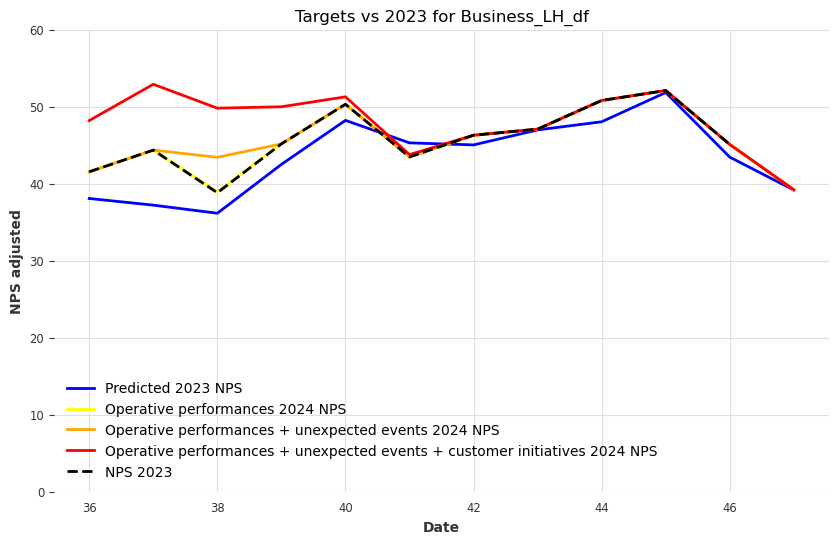

3.3107940741333213


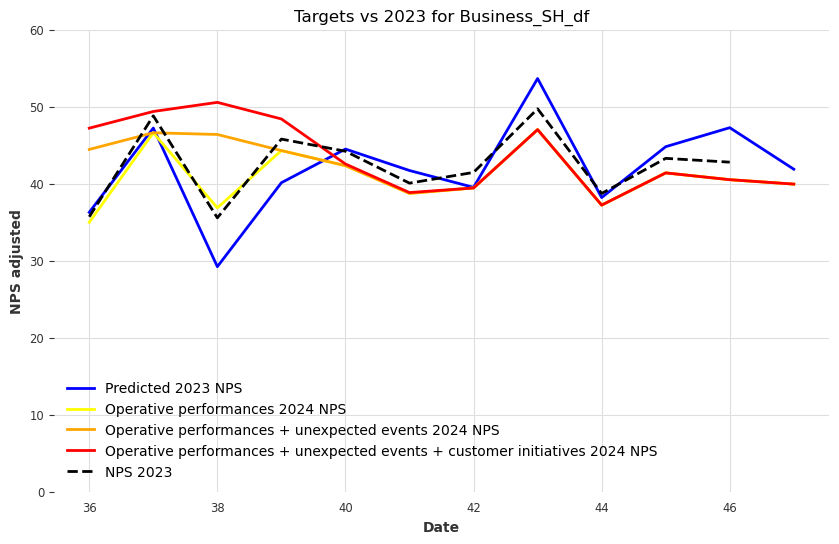

5.328171022746516


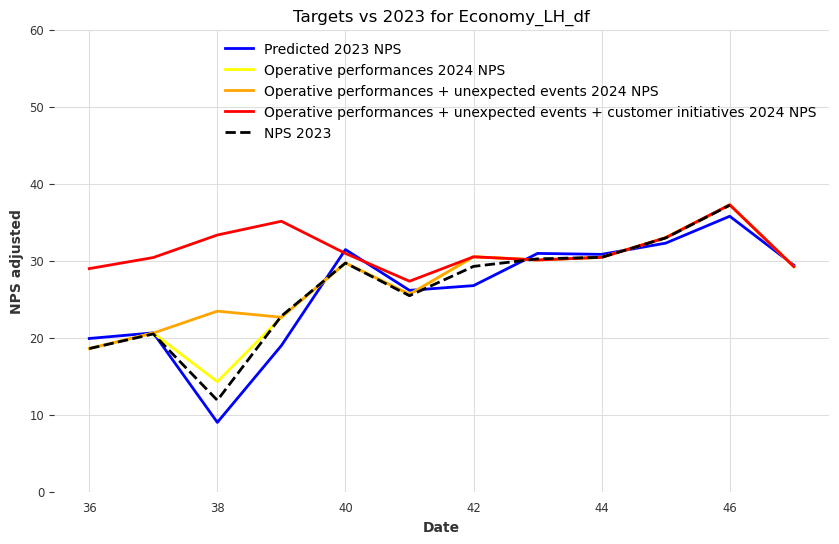

2.786442931930905


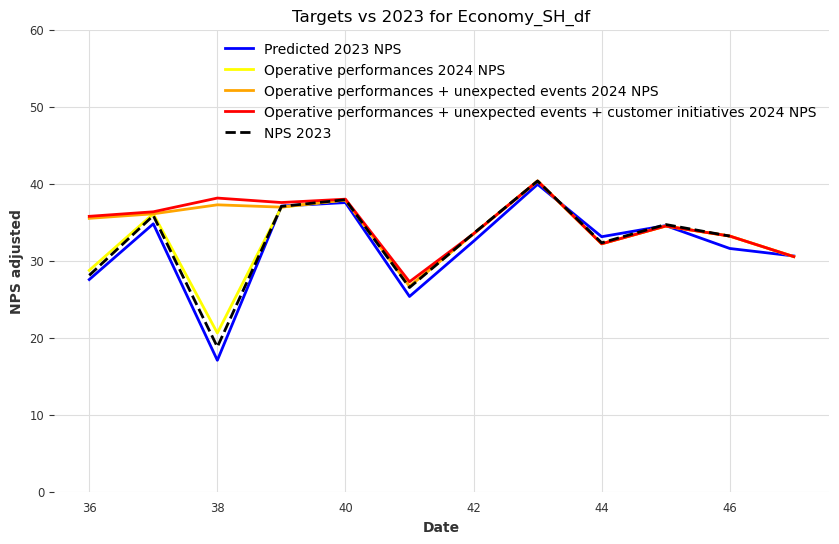

4.512823725781382


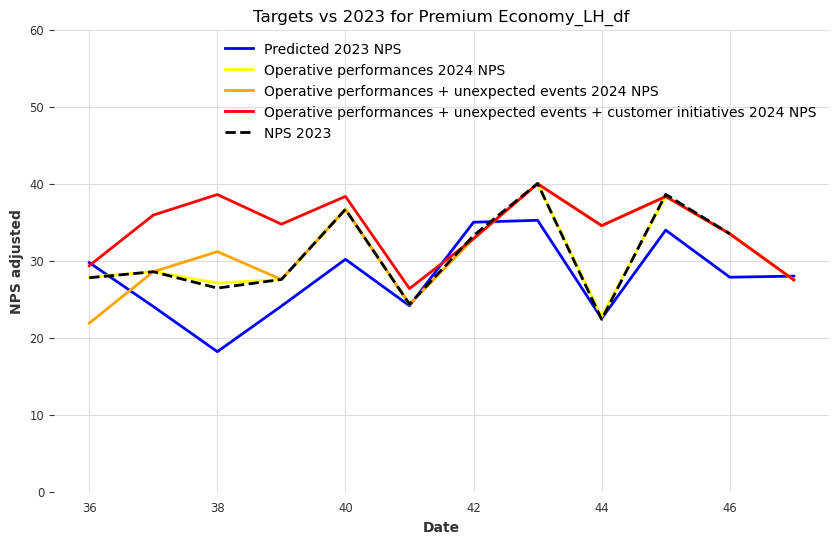

In [22]:
true_mae_agg_model={}
nps_ts={}
future_covariates_ts_1={}
future_covariates_ts_2={}
future_covariates_ts_3={}
future_covariates_ts_4={}

future_covariates_ts_scaled_1={}
future_covariates_ts_scaled_2={}
future_covariates_ts_scaled_3={}
future_covariates_ts_scaled_4={}

pred_series_1={}
pred_series_2={}
pred_series_3={}
pred_series_4={}

monthly_future_covariates_ts={}
monthly_future_covariates_ts_scaled={}
monthly_pred_series={}

nps_current_year={}
nps_last_year={}

best_tuned_models_by_dataframe={}
future_scaler_dict_mae={}

for key in monthly_operative_performance_grouped_dfs.keys(): 
    if key != 'Global_ _df':        
        pred_df_1=monthly_operative_performance_grouped_dfs[key].reset_index(drop=True)
        
        pred_df_2=monthly_unexpected_events_grouped_dfs[key].reset_index(drop=True)
        
        pred_df_3=monthly_current_customer_inititiatives_grouped_dfs[key].reset_index(drop=True)
        
        pred_df_4=monthly_next_year_customer_inititiatives_grouped_dfs[key].reset_index(drop=True)
        
        nps_ts[key]= TimeSeries.from_series(pred_df_1['NPS_weighted'])[:-12]
        
        nps_current_year[key]=TimeSeries.from_series(pred_df_1[(pred_df_1['date_flight_local'].dt.year==current_year)]['NPS_weighted'].reset_index(drop=True)).shift((num_full_available_years)*12)
        # nps_last_year[key]=TimeSeries.from_series(pred_df_1[(pred_df_1['date_flight_local'].dt.year==(current_year-1)])]['NPS_weighted'].reset_index(drop=True)).shift(36)
        
        # Load the pre-trained dataframe
        best_tuned_model_dataframe_path=os.path.join(experiment_dir, f"best_tuned_dataframe_{key}.pkl")
        with open(best_tuned_model_dataframe_path, 'rb') as dataframe_file:
            best_tuned_models_by_dataframe[key] = pickle.load(dataframe_file)
        
        # Load the pre-trained scaler
        future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
        with open(future_scaler_path, 'rb') as scaler_file:
            future_scaler_dict_mae[key] = pickle.load(scaler_file)
        
        
        value= best_tuned_models_by_dataframe[key]

        future_covariates_ts_1[key] = TimeSeries.from_series(pred_df_1[features_1[key]])[-12:]                
        future_scaler = future_scaler_dict_mae[key]
        future_covariates_ts_scaled_1[key] = future_scaler.transform(future_covariates_ts_1[key])
        
        future_covariates_ts_2[key] = TimeSeries.from_series(pred_df_2[features_2[key]])[-12:]                
        future_scaler = future_scaler_dict_mae[key]
        future_covariates_ts_scaled_2[key] = future_scaler.transform(future_covariates_ts_2[key])
        
        future_covariates_ts_3[key] = TimeSeries.from_series(pred_df_3[features_3[key]])[-12:]                
        future_scaler = future_scaler_dict_mae[key]
        future_covariates_ts_scaled_3[key] = future_scaler.transform(future_covariates_ts_3[key])
        
        future_covariates_ts_4[key] = TimeSeries.from_series(pred_df_4[features_4[key]])[-12:]                
        future_scaler = future_scaler_dict_mae[key]
        future_covariates_ts_scaled_4[key] = future_scaler.transform(future_covariates_ts_4[key])
        
        
        monthly_future_covariates_ts[key] = TimeSeries.from_series(pred_df_1[features_1[key]])[-24:-12]
        monthly_future_covariates_ts_scaled[key] = future_scaler.transform(monthly_future_covariates_ts[key])

        # Load the pre-trained model
        model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
        with open(model_file_path, 'rb') as model_file:
            model = pickle.load(model_file)


        pred_series_1[key] = model.predict(n=12, series=nps_ts[key][(last_available_month-12):],  future_covariates=future_covariates_ts_scaled_1[key])
        pred_series_2[key] = model.predict(n=12, series=nps_ts[key][(last_available_month-12):],  future_covariates=future_covariates_ts_scaled_2[key])
        pred_series_3[key] = model.predict(n=12, series=nps_ts[key][(last_available_month-12):],  future_covariates=future_covariates_ts_scaled_3[key])
        pred_series_4[key] = model.predict(n=12, series=nps_ts[key][(last_available_month-12):],  future_covariates=future_covariates_ts_scaled_4[key])
        
        monthly_pred_series[key] = model.predict(n=12, series=nps_ts[key][23:24],  future_covariates=monthly_future_covariates_ts_scaled[key])
        
        print(mae(pred_series_4[key], nps_current_year[key]))
        # pred_series[key]=pred_series[key]+ 2*mae(pred_series[key][:8], nps_current_year[key])
        plt.figure(figsize=(10, 6))
        
        # pred_series_1[key].plot(label='Predicted 2024 NPS', color='yellow')
        # pred_series_2[key].plot(label='Predicted 2024 NPS', color='orange')
        # pred_series_3[key].plot(label='Predicted 2024 NPS', color='red')
        
        monthly_pred_series[key].shift(12).plot(label='Predicted 2023 NPS', color='blue')
        
#         (nps_current_year[key]+pred_series_1[key]-monthly_pred_series[key].shift(12)).plot(label='Operative performances 2024 NPS', color= 'yellow', linestyle='-')  
#         (nps_current_year[key]+pred_series_2[key]-monthly_pred_series[key].shift(12)).plot(label='Operative performances + unexpected events 2024 NPS', color= 'orange', linestyle='-')
#         (nps_current_year[key]+pred_series_3[key]-monthly_pred_series[key].shift(12)).plot(label='Operative performances + unexpected events + customer initiatives 2024 NPS', color= 'red', linestyle='-')
        
        (nps_current_year[key][:last_available_month]+pred_series_1[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month]).append(pred_series_1[key][(last_available_month-12):]).plot(label='Operative performances 2024 NPS', color= 'yellow', linestyle='-')
        (nps_current_year[key][:last_available_month]+pred_series_2[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month]).append(pred_series_2[key][(last_available_month-12):]).plot(label='Operative performances + unexpected events 2024 NPS', color= 'orange', linestyle='-')
        (nps_current_year[key][:last_available_month]+pred_series_4[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month]).append(pred_series_4[key][(last_available_month-12):]).plot(label='Operative performances + unexpected events + customer initiatives 2024 NPS', color= 'red', linestyle='-')
        
        
        nps_current_year[key][:last_available_month].plot(label='NPS 2023', color= 'black', linestyle='--')
        plt.title(f"Targets vs 2023 for {key}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()     
        
        plt.ylim(0, 60)  # Set the y-axis limit from 0 to the maximum value
        #plt.savefig(f"{true_output_dir}/forecast_{key}_estimated_touchpoints.png")
        plt.show()
        
        from calendar import isleap, monthrange

        # Create a date string for filtering
        year = current_year
        month = last_available_month
        # Determine the last day of the month, considering leap years
        if month == 2:
            last_day = 29 if isleap(year) else 28
        else:
            last_day = monthrange(year, month)[1]
        date_string = f'{year}-{month}-{last_day}'

        NPS_df_1=monthly_pred_series[key][last_available_month:].append((nps_current_year[key][:last_available_month]+pred_series_1[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month])).append(pred_series_1[key][(last_available_month-12):]).pd_dataframe().reset_index(drop=True)
        indices_2024_1 = monthly_operative_performance_grouped_dfs[key]['date_flight_local'] > date_string
        nps_values_1 = NPS_df_1.values
        monthly_operative_performance_grouped_dfs[key].loc[indices_2024_1, 'NPS_weighted'] = nps_values_1


        
        NPS_df_2=monthly_pred_series[key][last_available_month:].append((nps_current_year[key][:last_available_month]+pred_series_2[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month])).append(pred_series_2[key][(last_available_month-12):]).pd_dataframe().reset_index(drop=True)
        indices_2024_2 = monthly_unexpected_events_grouped_dfs[key]['date_flight_local'] > date_string
        nps_values_2 = NPS_df_2.values
        monthly_unexpected_events_grouped_dfs[key].loc[indices_2024_2, 'NPS_weighted'] = nps_values_2
        
        NPS_df_3=monthly_pred_series[key][last_available_month:].append((nps_current_year[key][:last_available_month]+pred_series_3[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month])).append(pred_series_3[key][(last_available_month-12):]).pd_dataframe().reset_index(drop=True)
        indices_2024_3 = monthly_current_customer_inititiatives_grouped_dfs[key]['date_flight_local'] > date_string
        nps_values_3 = NPS_df_3.values
        monthly_current_customer_inititiatives_grouped_dfs[key].loc[indices_2024_3, 'NPS_weighted'] = nps_values_3
        
        NPS_df_4=monthly_pred_series[key][last_available_month:].append((nps_current_year[key][:last_available_month]+pred_series_4[key][:last_available_month]-monthly_pred_series[key].shift(12)[:last_available_month])).append(pred_series_4[key][(last_available_month-12):]).pd_dataframe().reset_index(drop=True)
        indices_2024_4 = monthly_next_year_customer_inititiatives_grouped_dfs[key]['date_flight_local'] > date_string
        nps_values_4 = NPS_df_4.values
        monthly_next_year_customer_inititiatives_grouped_dfs[key].loc[indices_2024_4, 'NPS_weighted'] = nps_values_4
        
        
       

        

### Save results

In [23]:
operative_performance_fp_df = pd.concat(monthly_operative_performance_grouped_dfs.values())
# Reset the index
operative_performance_fp_df.reset_index(drop=True, inplace=True)
# Save .csv
operative_performance_fp_df.to_csv(f'{current_directory}/outputs_prediction/{insert_date_ci}/operative_performance_fp_2024.csv')

In [24]:
unexpected_events_fp_df = pd.concat(monthly_unexpected_events_grouped_dfs.values())
# Reset the index
unexpected_events_fp_df.reset_index(drop=True, inplace=True)
# Save .csv
unexpected_events_fp_df.to_csv(f'{current_directory}/outputs_prediction/{insert_date_ci}/unexpected_events_fp_2024.csv')

In [25]:

customer_initiatives_fp_df = pd.concat(monthly_next_year_customer_inititiatives_grouped_dfs.values())
# Reset the index
customer_initiatives_fp_df.reset_index(drop=True, inplace=True)
# Save .csvNPS forecasting model/nps_model/Production Notebooks/3. Aggregated Model Notebooks/outputs_prediction/customer_initiatives_fp_2024.csv')
customer_initiatives_fp_df.to_csv(f'{current_directory}/outputs_prediction/{insert_date_ci}/customer_initiatives_fp_2024.csv')

## Yearly targets vs previous years

### Read the yearly target dataframes

In [26]:
# Read data from the specified sheet
annual_operative_performance_df = pd.read_csv(yearly_operative_performance_path)

In [27]:
annual_unexpected_events_df = pd.read_csv(yearly_unexpected_events_path)

In [28]:
annual_current_customer_initiatives_df = pd.read_csv(yearly_current_customer_initiatives_path)

In [29]:
annual_next_year_customer_initiatives_df = pd.read_csv(yearly_next_year_customer_initiatives_path)

### Group by cabin/haul and filter the model columns

In [30]:
annual_operative_performance_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)
annual_unexpected_events_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)
annual_current_customer_initiatives_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)
annual_next_year_customer_initiatives_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

In [31]:
annual_operative_performance_grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
yearly_grouped_1 = annual_operative_performance_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in yearly_grouped_1:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    annual_operative_performance_grouped_dfs[group_df_name] = group_df
    
for key in annual_operative_performance_grouped_dfs.keys():
    df = annual_operative_performance_grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2020 , 2022, 2023, 2024])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    annual_operative_performance_grouped_dfs[key] = df# Replace the grouped DataFrames with the original merged_df DataFrame
annual_operative_performance_df = pd.concat(annual_operative_performance_grouped_dfs.values())

# Reset the index
annual_operative_performance_df.reset_index(drop=True, inplace=True)

annual_unexpected_events_grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
yearly_grouped_2 = annual_unexpected_events_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in yearly_grouped_2:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    annual_unexpected_events_grouped_dfs[group_df_name] = group_df
    
for key in annual_unexpected_events_grouped_dfs.keys():
    df = annual_unexpected_events_grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2020 , 2022, 2023, 2024])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    annual_unexpected_events_grouped_dfs[key] = df# Replace the grouped DataFrames with the original merged_df DataFrame
annual_unexpected_events_df = pd.concat(annual_unexpected_events_grouped_dfs.values())

# Reset the index
annual_unexpected_events_df.reset_index(drop=True, inplace=True)

annual_current_customer_initiatives_grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
yearly_grouped_3 = annual_current_customer_initiatives_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in yearly_grouped_3:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    annual_current_customer_initiatives_grouped_dfs[group_df_name] = group_df
    
for key in annual_current_customer_initiatives_grouped_dfs.keys():
    df = annual_current_customer_initiatives_grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2020 , 2022, 2023, 2024])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    annual_current_customer_initiatives_grouped_dfs[key] = df# Replace the grouped DataFrames with the original merged_df DataFrame
annual_current_customer_initiatives_df = pd.concat(annual_current_customer_initiatives_grouped_dfs.values())

# Reset the index
annual_current_customer_initiatives_df.reset_index(drop=True, inplace=True)

annual_next_year_customer_initiatives_grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
yearly_grouped_4 = annual_next_year_customer_initiatives_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in yearly_grouped_4:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    annual_next_year_customer_initiatives_grouped_dfs[group_df_name] = group_df
    
for key in annual_next_year_customer_initiatives_grouped_dfs.keys():
    df = annual_next_year_customer_initiatives_grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2020 , 2022, 2023, 2024])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    annual_next_year_customer_initiatives_grouped_dfs[key] = df# Replace the grouped DataFrames with the original merged_df DataFrame
annual_next_year_customer_initiatives_df = pd.concat(annual_next_year_customer_initiatives_grouped_dfs.values())

# Reset the index
annual_next_year_customer_initiatives_df.reset_index(drop=True, inplace=True)

In [32]:
features={}
for df_id, df in annual_operative_performance_grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in annual_operative_performance_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in annual_operative_performance_df.columns if col.startswith('otp15_takeoff')] 
    #+ [col for col in monthly_df.columns if col.startswith('month_')] + [col for col in monthly_df.columns if col.startswith('year_')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    annual_operative_performance_grouped_dfs[df_id]=df
annual_operative_performance_df = pd.concat(annual_operative_performance_grouped_dfs.values())

# Reset the index
annual_operative_performance_df.reset_index(drop=True, inplace=True)

for df_id, df in annual_unexpected_events_grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in annual_unexpected_events_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in annual_unexpected_events_df.columns if col.startswith('otp15_takeoff')] 
    #+ [col for col in monthly_df.columns if col.startswith('month_')] + [col for col in monthly_df.columns if col.startswith('year_')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    annual_unexpected_events_grouped_dfs[df_id]=df
annual_unexpected_events_df = pd.concat(annual_unexpected_events_grouped_dfs.values())

# Reset the index
annual_unexpected_events_df.reset_index(drop=True, inplace=True)

for df_id, df in annual_current_customer_initiatives_grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in annual_current_customer_initiatives_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in annual_current_customer_initiatives_df.columns if col.startswith('otp15_takeoff')] 
    #+ [col for col in monthly_df.columns if col.startswith('month_')] + [col for col in monthly_df.columns if col.startswith('year_')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    annual_current_customer_initiatives_grouped_dfs[df_id]=df
annual_current_customer_initiatives_df = pd.concat(annual_current_customer_initiatives_grouped_dfs.values())

# Reset the index
annual_current_customer_initiatives_df.reset_index(drop=True, inplace=True)

for df_id, df in annual_next_year_customer_initiatives_grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in annual_next_year_customer_initiatives_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in annual_next_year_customer_initiatives_df.columns if col.startswith('otp15_takeoff')] 
    #+ [col for col in monthly_df.columns if col.startswith('month_')] + [col for col in monthly_df.columns if col.startswith('year_')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    annual_next_year_customer_initiatives_grouped_dfs[df_id]=df
annual_next_year_customer_initiatives_df = pd.concat(annual_next_year_customer_initiatives_grouped_dfs.values())

# Reset the index
annual_next_year_customer_initiatives_df.reset_index(drop=True, inplace=True)

#### Substitute touchpoints values for true 2023 values for first scenerio

This is done because the computed mean values that we take as annual satisfaction values differ from the real satisfaction values (computing the mean is not perfect). In orden to have proper shaps plots we set this cell. It can be remove to further investigation and the code will still work.

In [33]:
# Filter yearly_df for the year 2024
annual_unexpected_events_df024 = annual_operative_performance_df[annual_operative_performance_df['date_flight_local'].dt.year == 2024]

# Filter true_yearly_df for the year 2023
true_annual_unexpected_events_df023 = annual_operative_performance_df[annual_operative_performance_df['date_flight_local'].dt.year == current_year]

# List of columns to update (excluding specified columns)
columns_to_update = [col for col in annual_unexpected_events_df024.columns if col not in ['date_flight_local', 'cabin', 'haul', 'otp15_takeoff', 'load_factor']]

# Substitute values in columns from 2024 with corresponding values from 2023
for col in columns_to_update:
    annual_operative_performance_df.loc[annual_unexpected_events_df024.index, col] = true_annual_unexpected_events_df023[col].values


In [34]:
annual_operative_performance_grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
yearly_grouped_1 = annual_operative_performance_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in yearly_grouped_1:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    annual_operative_performance_grouped_dfs[group_df_name] = group_df

### Make predictions for each scenerario

In [35]:
true_mae_agg_model={}
nps_ts={}
future_covariates_ts={}
future_covariates_ts_scaled={}
pred_series={}

# yearly_future_covariates_ts={}
# yearly_future_covariates_ts_scaled={}
# yearly_pred_series={}

nps_current_year={}
nps_last_year={}

print(annual_next_year_customer_initiatives_grouped_dfs.keys())

for key in annual_next_year_customer_initiatives_grouped_dfs.keys(): 
        aux_df=annual_next_year_customer_initiatives_grouped_dfs[key].reset_index(drop=True) 
        aux_df['date_flight_local'] = aux_df['date_flight_local'].dt.strftime('%Y-01-01')
        aux_df['date_flight_local'] = pd.to_datetime(aux_df['date_flight_local'])
        
        # Load the pre-trained dataframe
        best_tuned_model_dataframe_path=os.path.join(experiment_dir, f"best_tuned_dataframe_{key}.pkl")
        with open(best_tuned_model_dataframe_path, 'rb') as dataframe_file:
            best_tuned_models_by_dataframe[key] = pickle.load(dataframe_file)
        
        # Load the pre-trained scaler
        future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
        with open(future_scaler_path, 'rb') as scaler_file:
            future_scaler_dict_mae[key] = pickle.load(scaler_file)

        aux_df = aux_df.set_index('date_flight_local')
        nps_ts[key]= TimeSeries.from_series(aux_df['NPS_weighted'])
        value= best_tuned_models_by_dataframe[key]

        future_covariates_ts[key] = TimeSeries.from_series(aux_df[features[key]])[1:]                
        future_scaler = future_scaler_dict_mae[key]
        future_covariates_ts_scaled[key] = future_scaler.transform(future_covariates_ts[key])

        # Load the pre-trained model
        model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
        with open(model_file_path, 'rb') as model_file:
            model = pickle.load(model_file)


        pred_series[key] = model.predict(n=4, series=nps_ts[key][:1],  future_covariates=future_covariates_ts_scaled[key])
        
        # print(f'The MAE of the model is:', mae(pred_series[key][:8],nps_ts[key]))
        
#         plt.figure(figsize=(10, 6))
#         pred_series_1[key].plot(label='Predicted NPS', color='red')
#         nps_ts[key][1:].plot(label='Real NPS', color='black', linestyle='--')

#         plt.title(f"Targets vs 2023 for {key}")
#         plt.xlabel("Date")
#         plt.ylabel("NPS adjusted")
#         plt.legend()

#         # Set y-axis to start at 0
#         max_value = max(pred_series_1[key].values().max(), nps_ts[key][1:].values().max())  # Get the maximum value
#         plt.ylim(0, 55)  # Set the y-axis limit from 0 to the maximum value

#         plt.show()

#         print('The predicted NPS for 2024 yearly targets is:', pred_series[key][(last_available_month-12):].values())

dict_keys(['Business_LH_df', 'Business_SH_df', 'Economy_LH_df', 'Economy_SH_df', 'Premium Economy_LH_df'])


### Get shapley explanations per cabin/haul for each scenario

In [36]:
import shap
operative_performance_explanation={}
operative_performance_explanation_objects = {}  # Initialize an empty dictionary to store SHAP explanation objects

for key in annual_operative_performance_grouped_dfs.keys():
    ts = pred_series_1[key][1:]
    back_ts = nps_ts[key]
    exp_df = annual_operative_performance_grouped_dfs[key].reset_index(drop=True)
    
    # Load the pre-trained dataframe
    best_tuned_model_dataframe_path=os.path.join(experiment_dir, f"best_tuned_dataframe_{key}.pkl")
    with open(best_tuned_model_dataframe_path, 'rb') as dataframe_file:
        best_tuned_models_by_dataframe[key] = pickle.load(dataframe_file)
        
    # Load the pre-trained scaler
    future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
    with open(future_scaler_path, 'rb') as scaler_file:
        future_scaler_dict_mae[key] = pickle.load(scaler_file)

    #past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(exp_df[features[key]])[1:]


    future_scaler = future_scaler_dict_mae[key]
    future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

    value= best_tuned_models_by_dataframe[key]

    # Load the pre-trained model
    model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)
    
    shap_explain = ShapExplainer(model=model)
    shap_explained = shap_explain.explain(ts, foreground_future_covariates=future_covariates_ts_scaled)
    operative_performance_explanation[key] = shap_explained.get_shap_explanation_object(horizon=1)

#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         past_lags=best_tuned_mae_models_by_dataframe[key]['params']['lags_past_covariates']
    future_lags=value['params']['lags_future_covariates']

#     # Apply the transformation for each lag in past_lags
#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         for lag in past_lags:
#             # Select columns for the current lag of past covariates
#             current_past_covariates_indices = [i for i, feature in enumerate(explanation[key].feature_names) if f"pastcov_lag{lag}" in feature]
#             # Select data for the current lag of past covariates
#             data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]

#             # Apply the transformation and store the result
#             transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
#             explanation[key].data[:, current_past_covariates_indices] = transformed_past_data

    # Apply the transformation for each lag in future_lags
    for lag in future_lags:
        # Select columns for the current lag of future covariates
        current_future_covariates_indices = [i for i, feature in enumerate(operative_performance_explanation[key].feature_names) if f"futcov_lag{lag}" in feature]

        # Select data for the current lag of future covariates
        data_for_current_future_covariates = operative_performance_explanation[key].data[:, current_future_covariates_indices]

        # Apply the transformation and store the result
        transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()

        operative_performance_explanation[key].data[:, current_future_covariates_indices] = transformed_future_data
    
    operative_performance_explanation_objects[key] = create_uplifting_explanation(operative_performance_explanation[key][2], operative_performance_explanation[key][3])
    # shap.plots.waterfall(shap_values=operative_performance_explanation_objects[key], max_display=20)


In [37]:
import shap
unexpected_events_explanation={}
unexpected_events_explanation_objects = {}  # Initialize an empty dictionary to store SHAP explanation objects

for key in annual_unexpected_events_grouped_dfs.keys():
    # Load the pre-trained dataframe
    ts = pred_series_2[key][1:]
    back_ts = nps_ts[key]
    exp_df = annual_unexpected_events_grouped_dfs[key].reset_index(drop=True)
    
    # Load the pre-trained scaler
    future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
    with open(future_scaler_path, 'rb') as scaler_file:
        future_scaler_dict_mae[key] = pickle.load(scaler_file)

    #past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(exp_df[features[key]])[1:]


    future_scaler = future_scaler_dict_mae[key]
    future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

    # Load the pre-trained model
    model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)
    
    shap_explain = ShapExplainer(model=model)
    shap_explained = shap_explain.explain(ts, foreground_future_covariates=future_covariates_ts_scaled)
    unexpected_events_explanation[key] = shap_explained.get_shap_explanation_object(horizon=1)

#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         past_lags=best_tuned_mae_models_by_dataframe[key]['params']['lags_past_covariates']
    future_lags=value['params']['lags_future_covariates']

#     # Apply the transformation for each lag in past_lags
#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         for lag in past_lags:
#             # Select columns for the current lag of past covariates
#             current_past_covariates_indices = [i for i, feature in enumerate(explanation[key].feature_names) if f"pastcov_lag{lag}" in feature]
#             # Select data for the current lag of past covariates
#             data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]

#             # Apply the transformation and store the result
#             transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
#             explanation[key].data[:, current_past_covariates_indices] = transformed_past_data

    # Apply the transformation for each lag in future_lags
    for lag in future_lags:
        # Select columns for the current lag of future covariates
        current_future_covariates_indices = [i for i, feature in enumerate(unexpected_events_explanation[key].feature_names) if f"futcov_lag{lag}" in feature]

        # Select data for the current lag of future covariates
        data_for_current_future_covariates = unexpected_events_explanation[key].data[:, current_future_covariates_indices]

        # Apply the transformation and store the result
        transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()

        unexpected_events_explanation[key].data[:, current_future_covariates_indices] = transformed_future_data
    
    unexpected_events_explanation_objects[key] = create_uplifting_explanation(unexpected_events_explanation[key][2], unexpected_events_explanation[key][3])

#     shap.plots.waterfall(shap_values=unexpected_events_explanation_objects[key], max_display=20)  # Display the waterfall plot for each key

In [38]:
import shap
current_customer_initiatives_explanation={}
current_customer_initiatives_explanation_objects = {}  # Initialize an empty dictionary to store SHAP explanation objects

for key in annual_current_customer_initiatives_grouped_dfs.keys():
    ts = pred_series_3[key][1:]
    back_ts = nps_ts[key]
    exp_df = annual_current_customer_initiatives_grouped_dfs[key].reset_index(drop=True)
    
    # Load the pre-trained scaler
    future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
    with open(future_scaler_path, 'rb') as scaler_file:
        future_scaler_dict_mae[key] = pickle.load(scaler_file)

    #past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(exp_df[features[key]])[1:]


    future_scaler = future_scaler_dict_mae[key]
    future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

    # Load the pre-trained model
    model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)
    
    shap_explain = ShapExplainer(model=model)
    shap_explained = shap_explain.explain(ts, foreground_future_covariates=future_covariates_ts_scaled)
    current_customer_initiatives_explanation[key] = shap_explained.get_shap_explanation_object(horizon=1)

#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         past_lags=best_tuned_mae_models_by_dataframe[key]['params']['lags_past_covariates']
    future_lags=value['params']['lags_future_covariates']

#     # Apply the transformation for each lag in past_lags
#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         for lag in past_lags:
#             # Select columns for the current lag of past covariates
#             current_past_covariates_indices = [i for i, feature in enumerate(explanation[key].feature_names) if f"pastcov_lag{lag}" in feature]
#             # Select data for the current lag of past covariates
#             data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]

#             # Apply the transformation and store the result
#             transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
#             explanation[key].data[:, current_past_covariates_indices] = transformed_past_data

    # Apply the transformation for each lag in future_lags
    for lag in future_lags:
        # Select columns for the current lag of future covariates
        current_future_covariates_indices = [i for i, feature in enumerate(current_customer_initiatives_explanation[key].feature_names) if f"futcov_lag{lag}" in feature]

        # Select data for the current lag of future covariates
        data_for_current_future_covariates = current_customer_initiatives_explanation[key].data[:, current_future_covariates_indices]

        # Apply the transformation and store the result
        transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()

        current_customer_initiatives_explanation[key].data[:, current_future_covariates_indices] = transformed_future_data
    
    current_customer_initiatives_explanation_objects[key] = create_uplifting_explanation(current_customer_initiatives_explanation[key][2], current_customer_initiatives_explanation[key][3])

#     shap.plots.waterfall(shap_values=current_customer_initiatives_explanation_objects[key], max_display=20)  # Display the waterfall plot for each key

In [39]:
import shap
next_year_customer_initiatives_explanation={}
next_year_customer_initiatives_explanation_objects = {}  # Initialize an empty dictionary to store SHAP explanation objects

for key in annual_next_year_customer_initiatives_grouped_dfs.keys():
    ts = pred_series_4[key][1:]
    back_ts = nps_ts[key]
    exp_df = annual_next_year_customer_initiatives_grouped_dfs[key].reset_index(drop=True)
        
    # Load the pre-trained scaler
    future_scaler_path = os.path.join(experiment_dir, f"future_scaler_{key}.pkl")
    with open(future_scaler_path, 'rb') as scaler_file:
        future_scaler_dict_mae[key] = pickle.load(scaler_file)

    #past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(exp_df[features[key]])[1:]


    future_scaler = future_scaler_dict_mae[key]
    future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

    # Load the pre-trained model
    model_file_path = os.path.join(experiment_dir, f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)
    
    shap_explain = ShapExplainer(model=model)
    shap_explained = shap_explain.explain(ts, foreground_future_covariates=future_covariates_ts_scaled)
    next_year_customer_initiatives_explanation[key] = shap_explained.get_shap_explanation_object(horizon=1)

#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         past_lags=best_tuned_mae_models_by_dataframe[key]['params']['lags_past_covariates']
    future_lags=value['params']['lags_future_covariates']

#     # Apply the transformation for each lag in past_lags
#     if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#         for lag in past_lags:
#             # Select columns for the current lag of past covariates
#             current_past_covariates_indices = [i for i, feature in enumerate(explanation[key].feature_names) if f"pastcov_lag{lag}" in feature]
#             # Select data for the current lag of past covariates
#             data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]

#             # Apply the transformation and store the result
#             transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
#             explanation[key].data[:, current_past_covariates_indices] = transformed_past_data

    # Apply the transformation for each lag in future_lags
    for lag in future_lags:
        # Select columns for the current lag of future covariates
        current_future_covariates_indices = [i for i, feature in enumerate(next_year_customer_initiatives_explanation[key].feature_names) if f"futcov_lag{lag}" in feature]

        # Select data for the current lag of future covariates
        data_for_current_future_covariates = next_year_customer_initiatives_explanation[key].data[:, current_future_covariates_indices]

        # Apply the transformation and store the result
        transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()

        next_year_customer_initiatives_explanation[key].data[:, current_future_covariates_indices] = transformed_future_data
    
    next_year_customer_initiatives_explanation_objects[key] = create_uplifting_explanation(next_year_customer_initiatives_explanation[key][2], next_year_customer_initiatives_explanation[key][3])
    # print(key)
    # shap.plots.waterfall(shap_values=next_year_customer_initiatives_explanation_objects[key], max_display=20)  # Display the waterfall plot for each key

### Create uplifting plots for each cabin/haul

#### From current year to + operative performances:

Business_LH_df


ValueError: Image size of -294479976x863 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x1000 with 3 Axes>

Business_SH_df


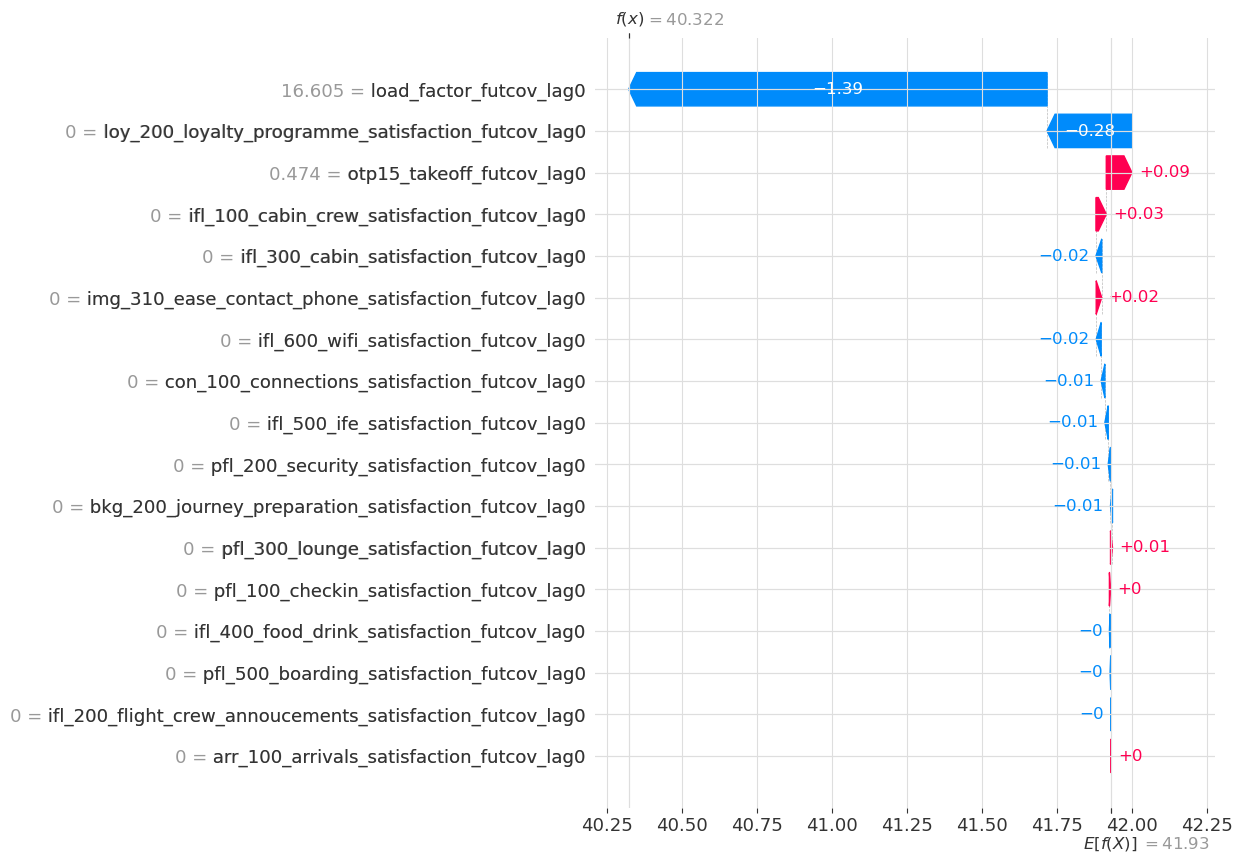

Economy_LH_df


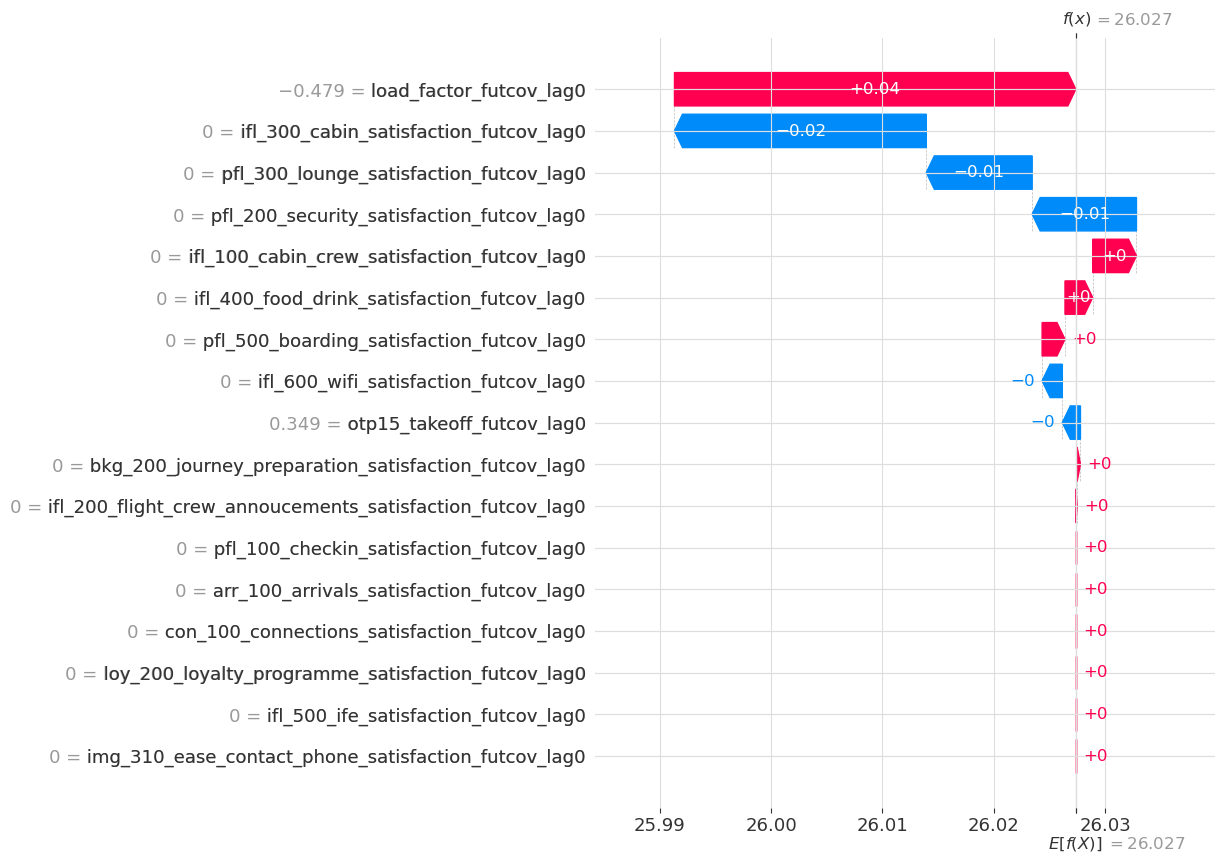

Economy_SH_df


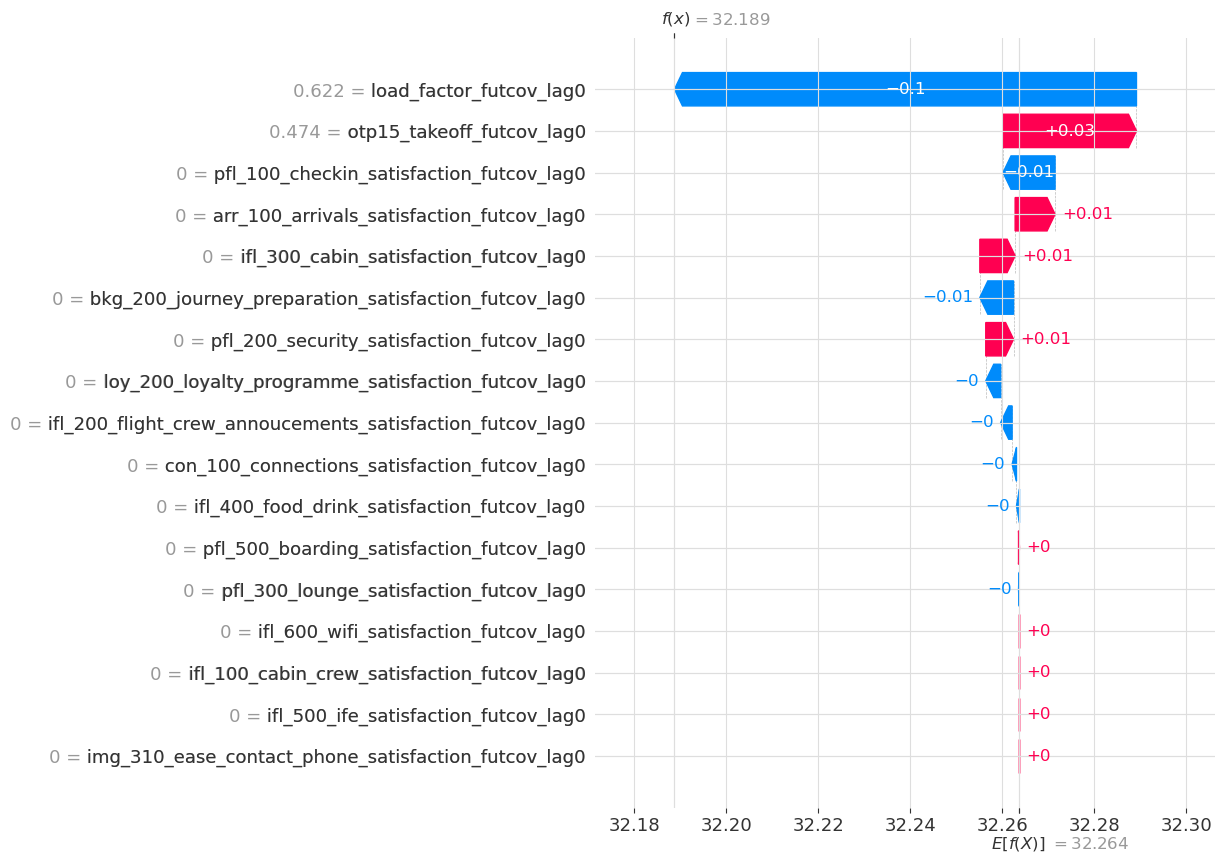

Premium Economy_LH_df


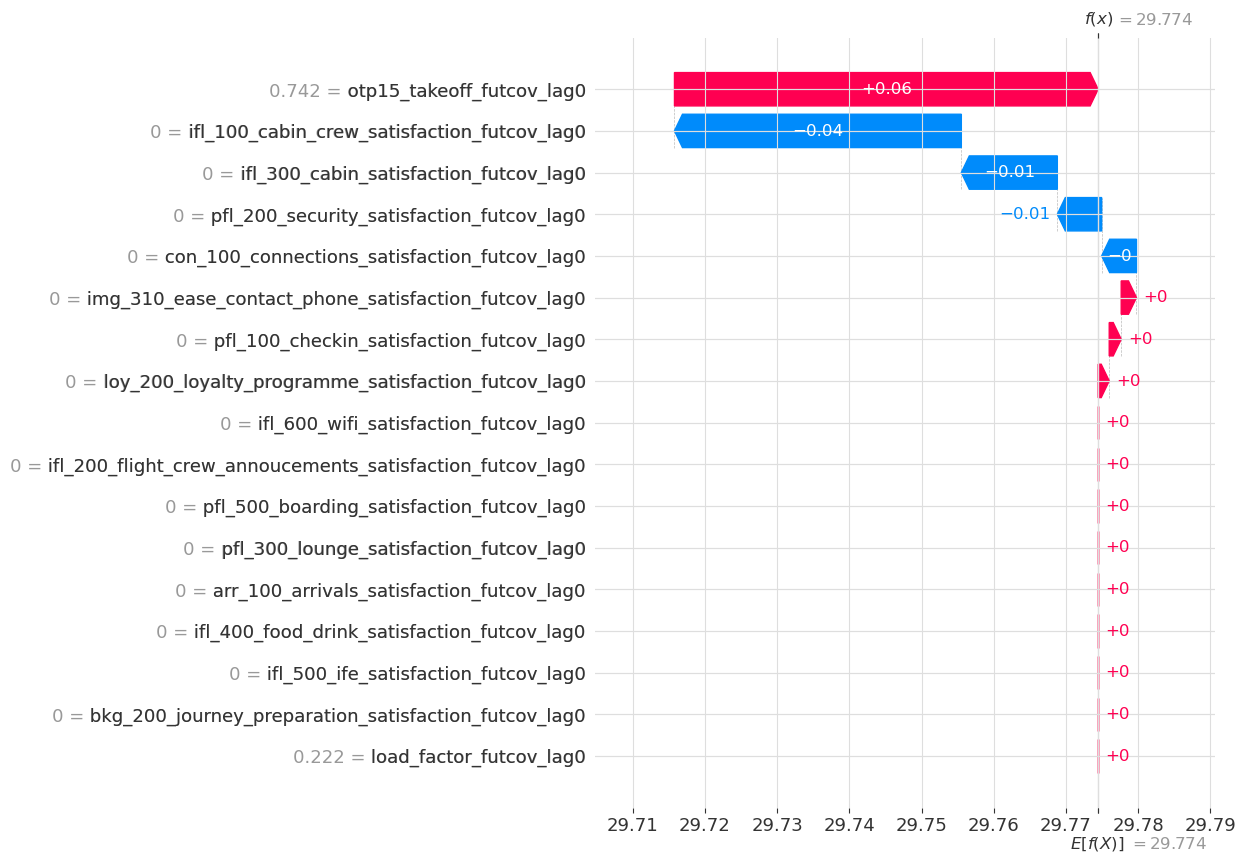

In [40]:
opertive_performances={}
for key in annual_next_year_customer_initiatives_grouped_dfs.keys(): 
    opertive_performances[key] = create_uplifting_explanation(operative_performance_explanation[key][2], operative_performance_explanation[key][3] )
    print(key)
    shap.plots.waterfall(shap_values=opertive_performances[key], max_display=20)  # Display the waterfall plot for each key

#### From +operative performances to (+operative performances and +unexpected events).

Business_LH_df


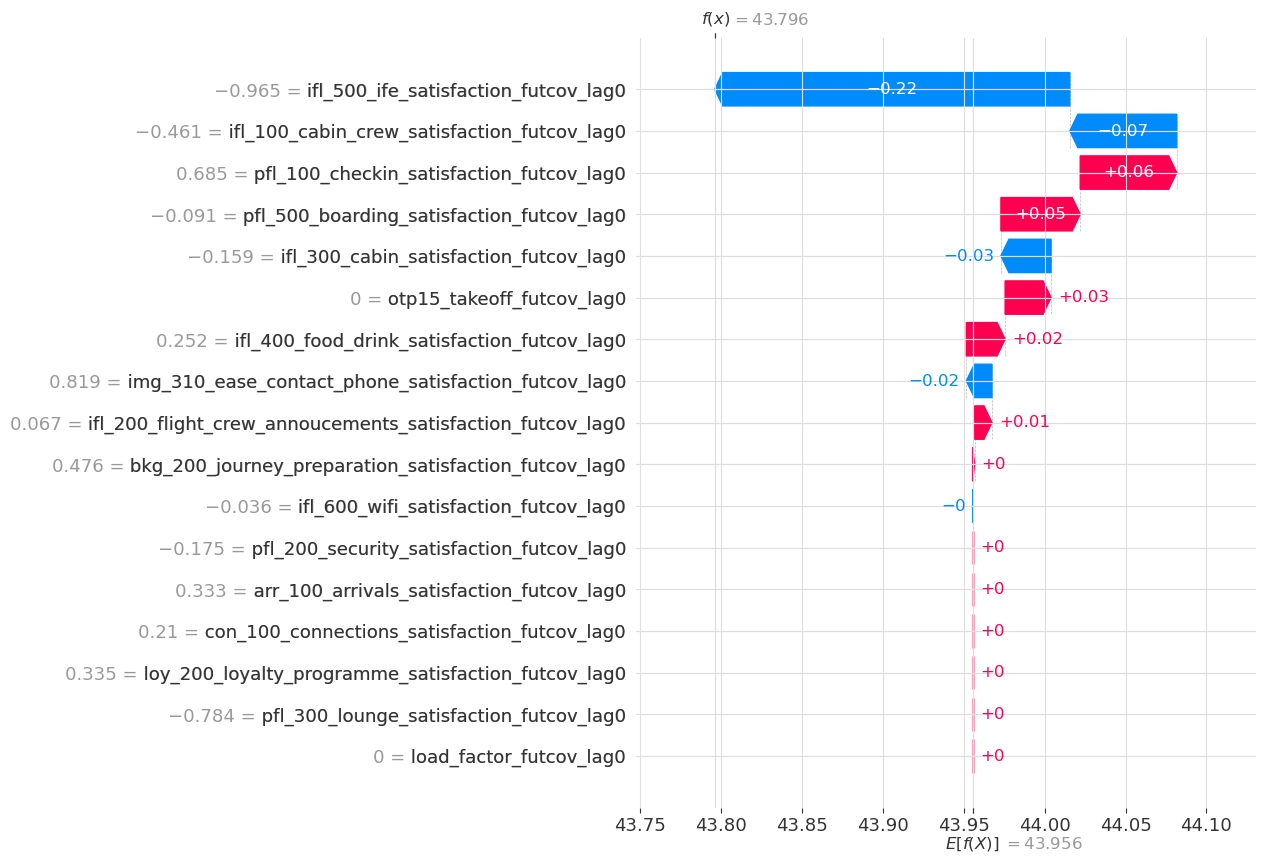

Business_SH_df


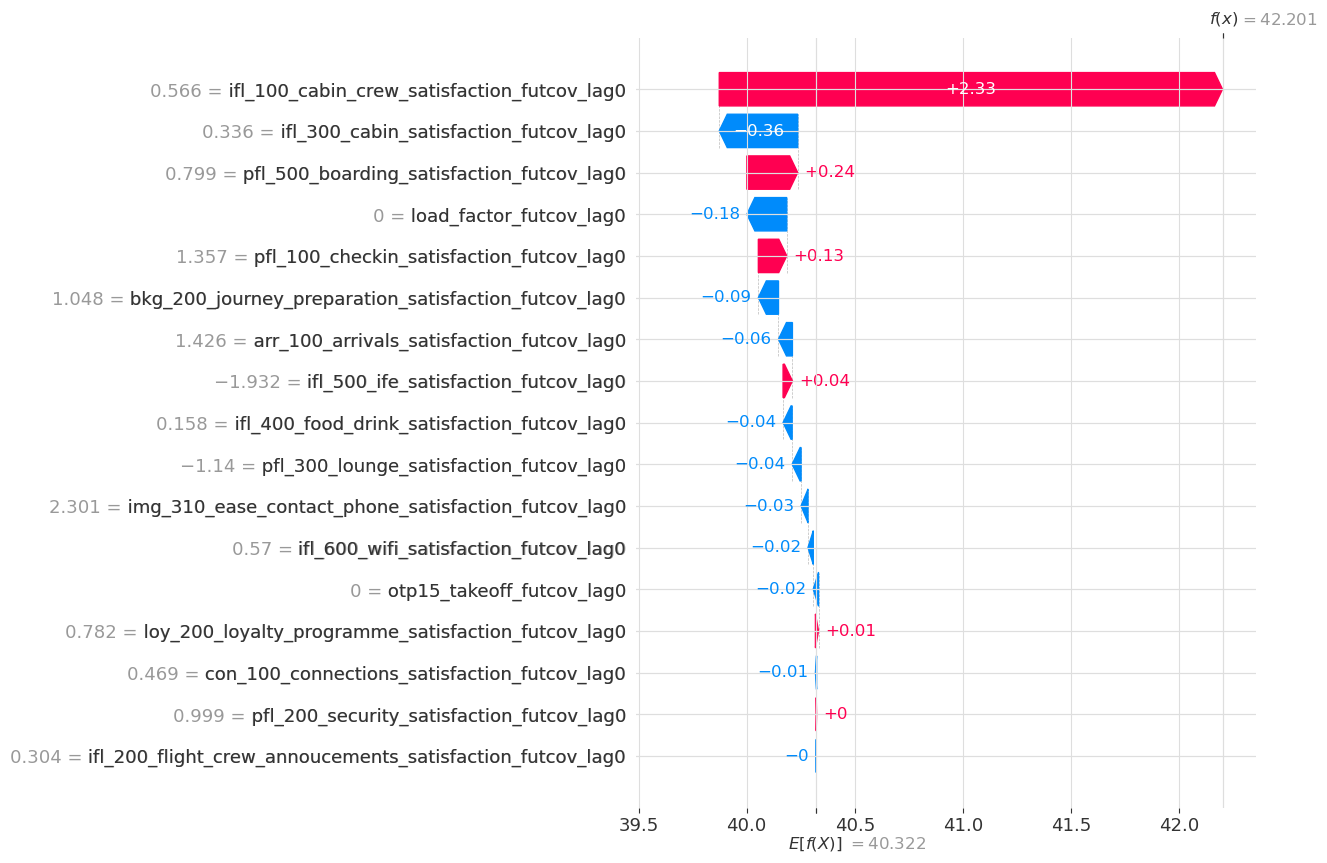

Economy_LH_df


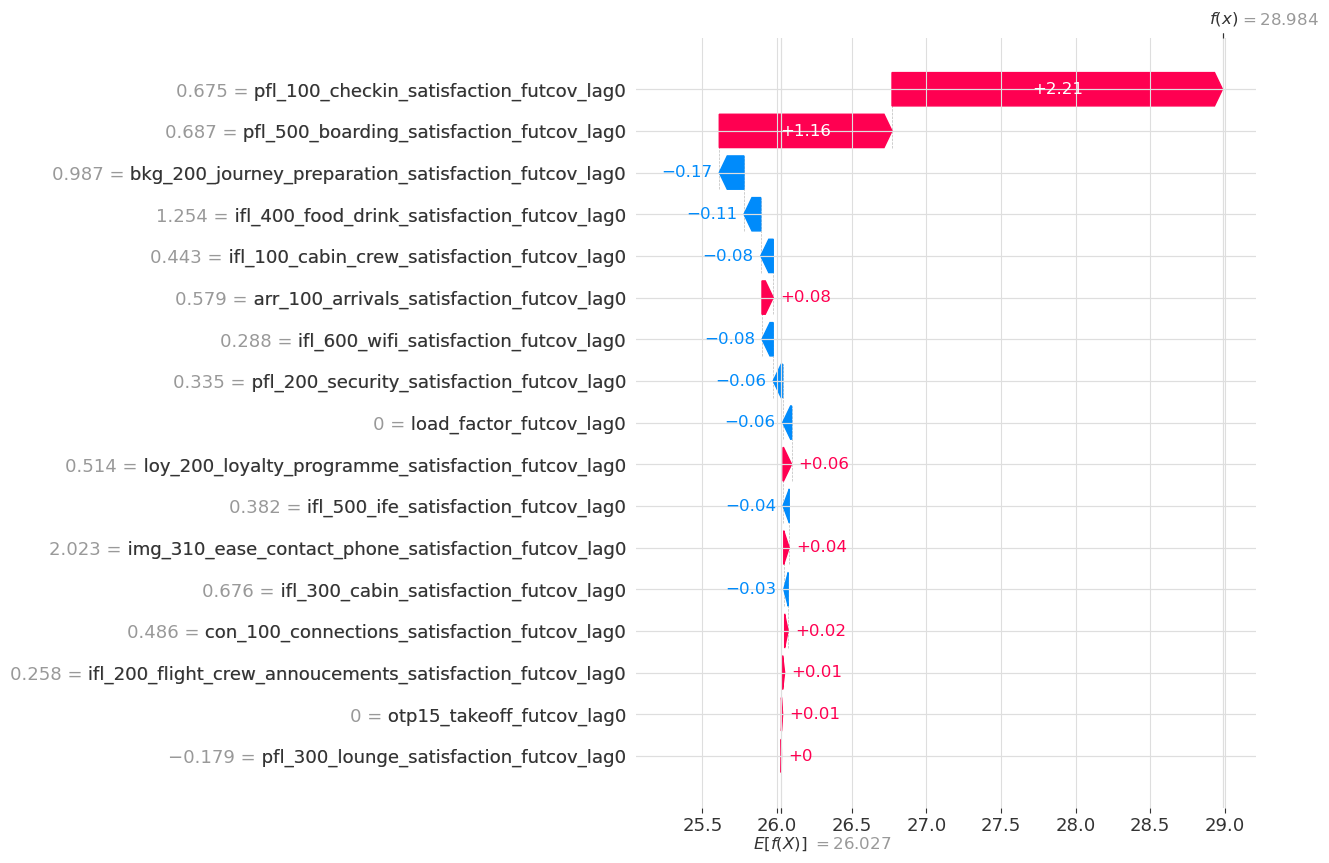

Economy_SH_df


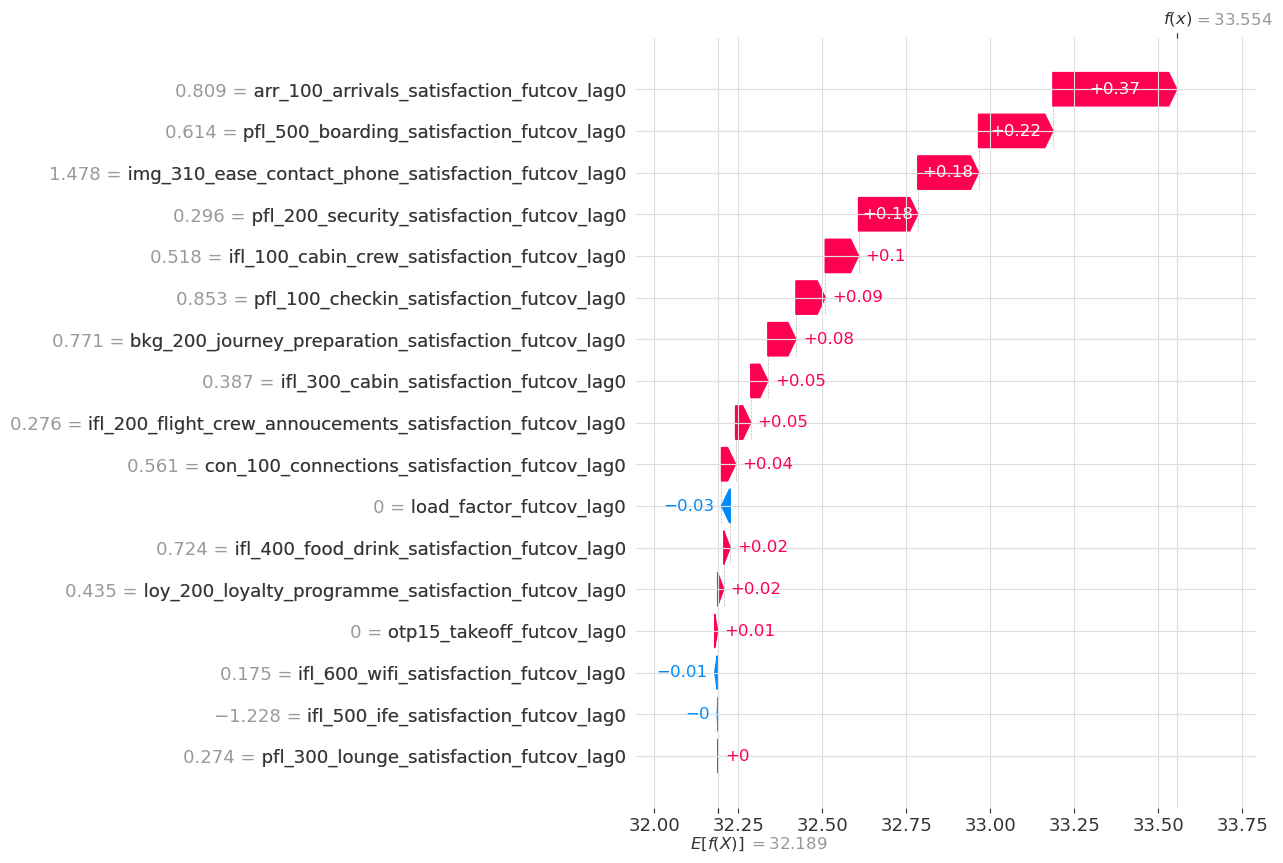

Premium Economy_LH_df


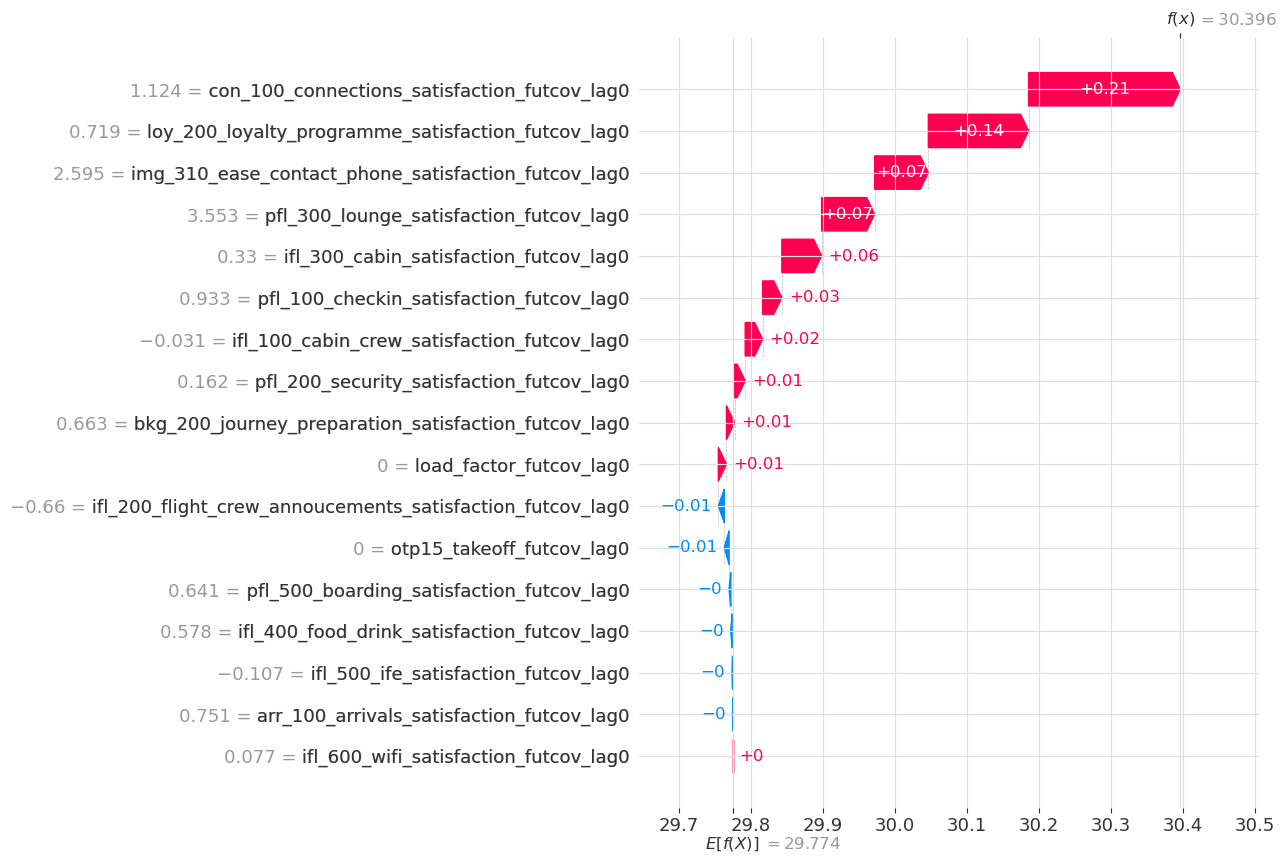

In [41]:
unexpected_events={}
for key in annual_next_year_customer_initiatives_grouped_dfs.keys(): 
    unexpected_events[key] = create_uplifting_explanation(operative_performance_explanation[key][3], unexpected_events_explanation[key][3] )
    print(key)
    shap.plots.waterfall(shap_values=unexpected_events[key], max_display=20)  # Display the waterfall plot for each key

#### From (+operative performances and +unexpected events) to (+operative performances and +unexpected events and + current customer inititiatives)

Business_LH_df


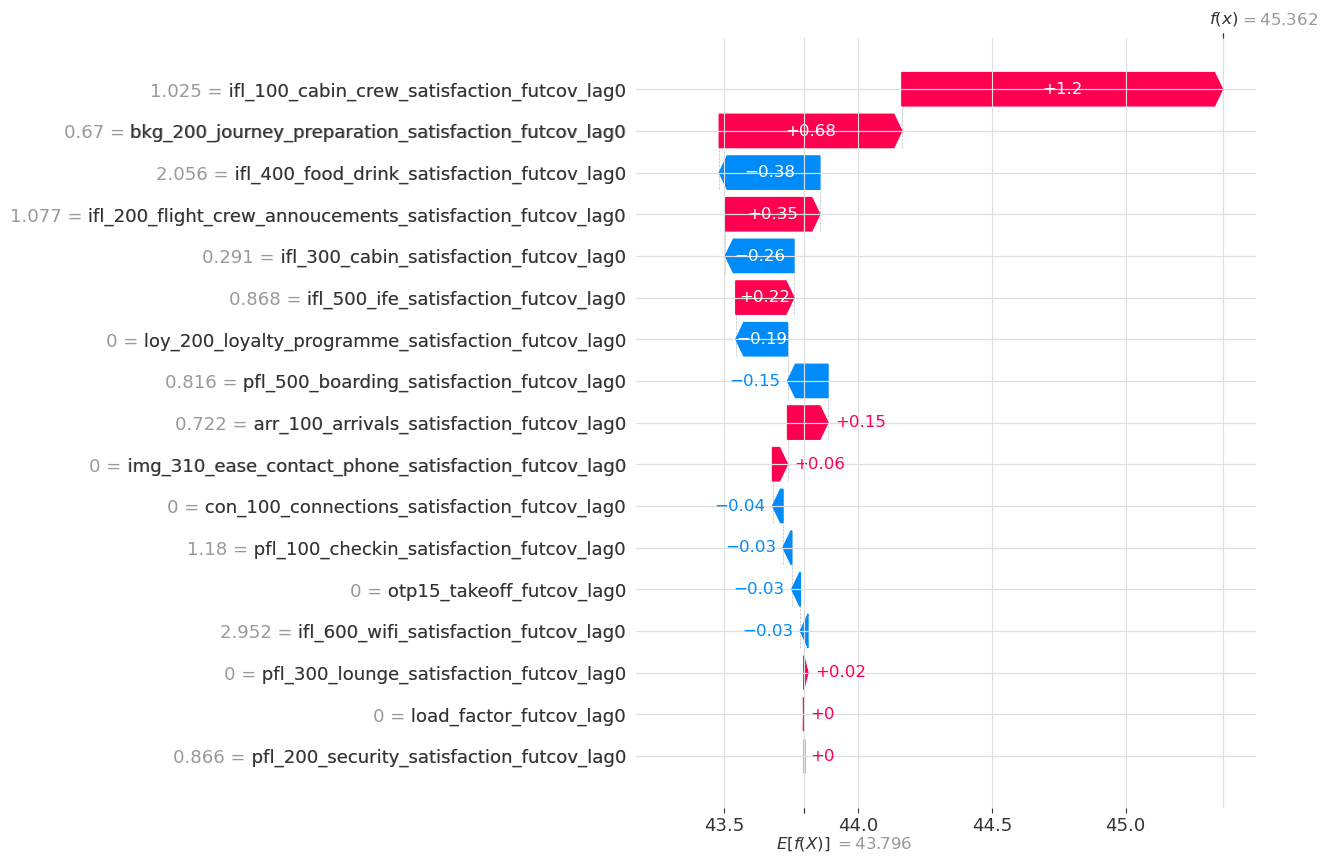

Business_SH_df


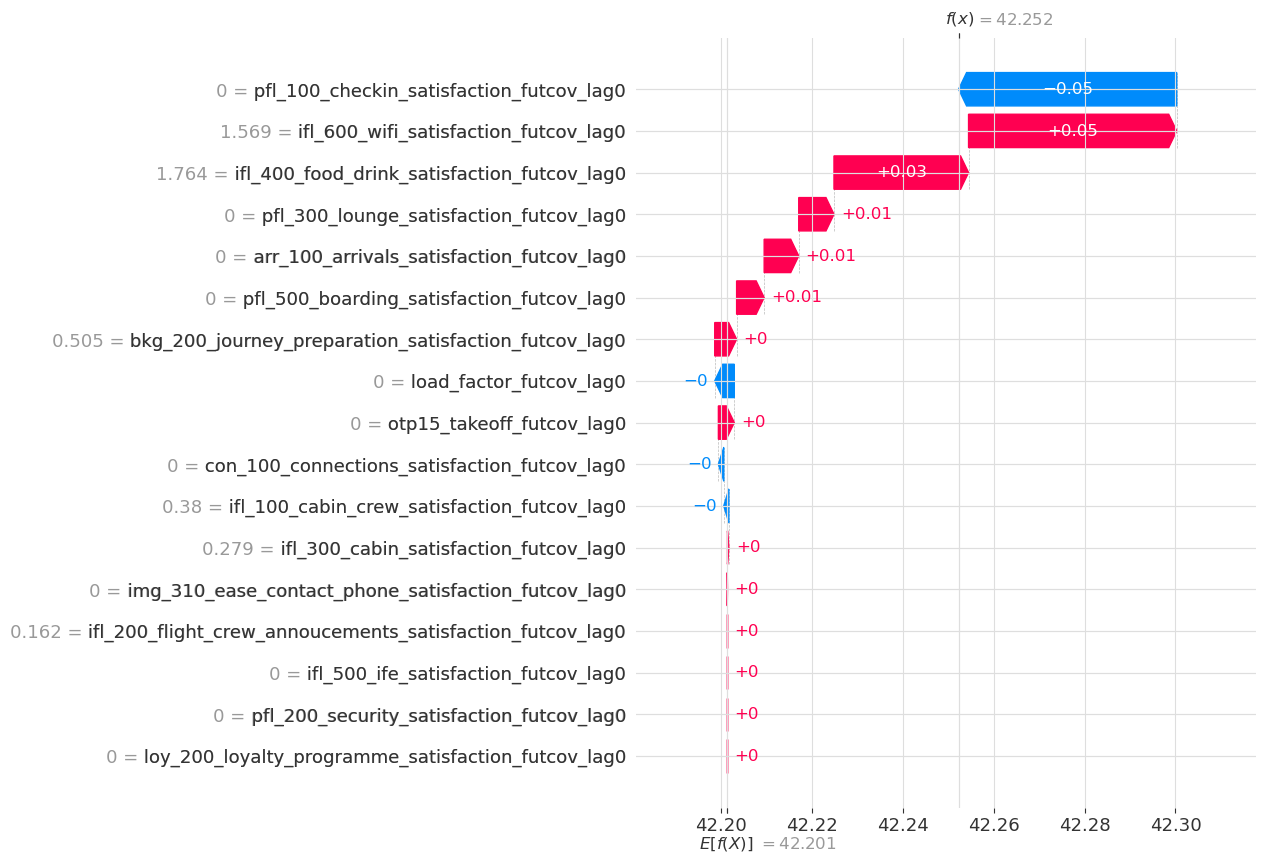

Economy_LH_df


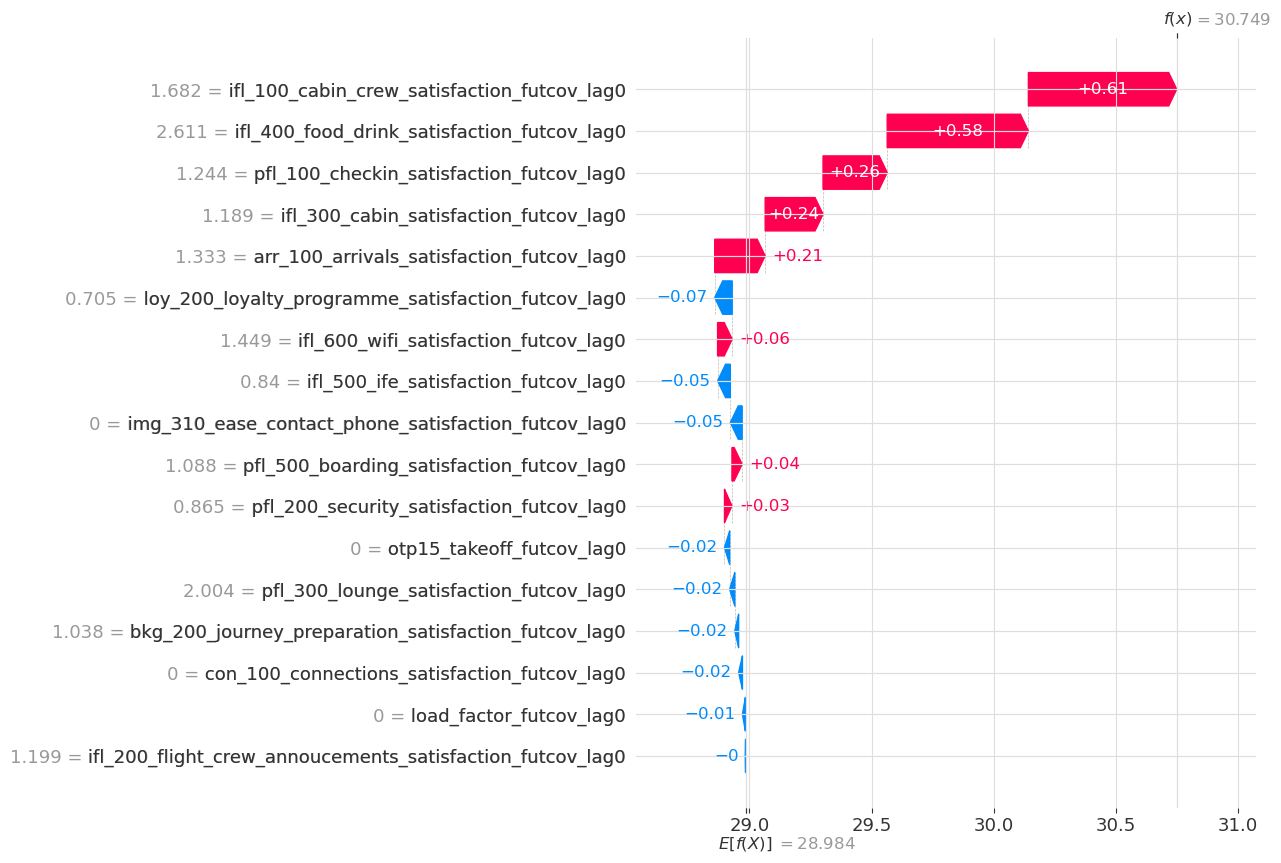

Economy_SH_df


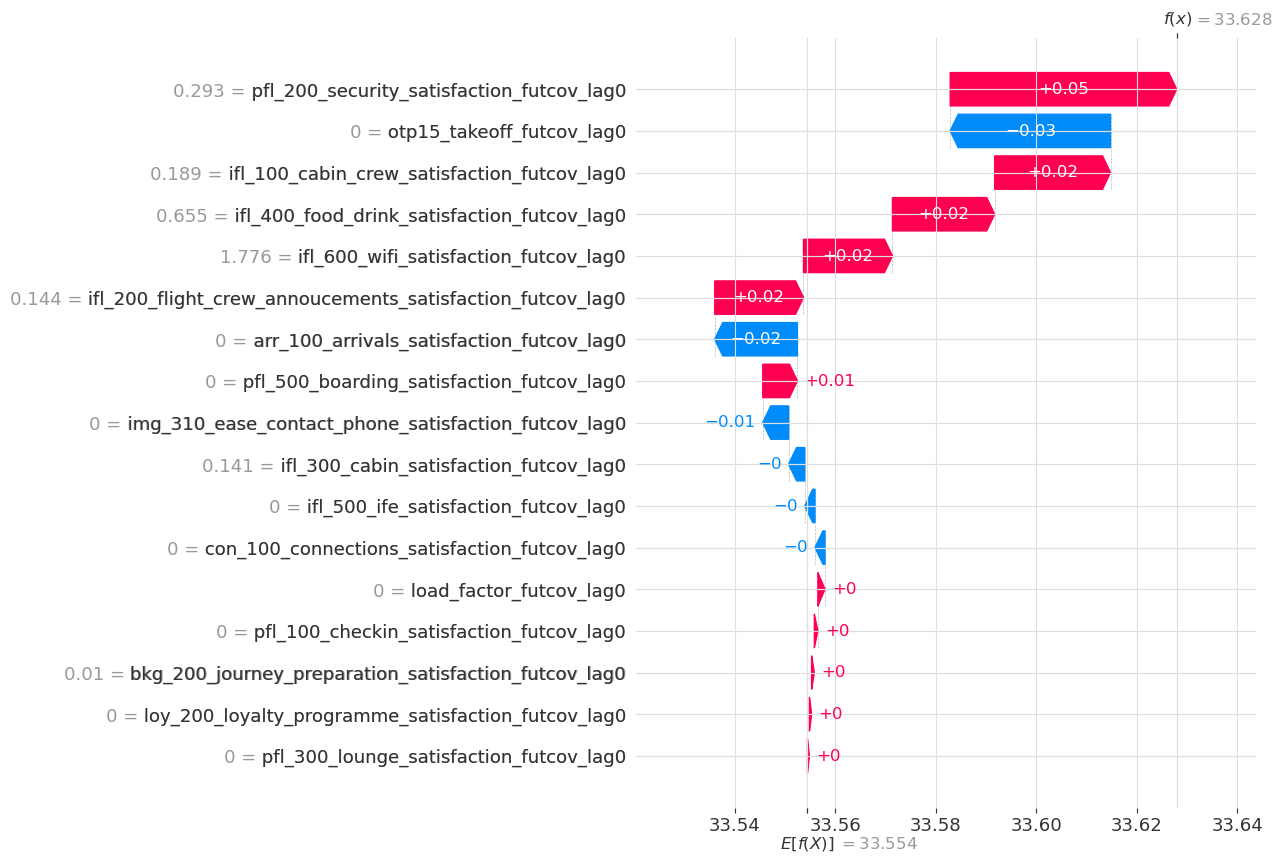

Premium Economy_LH_df


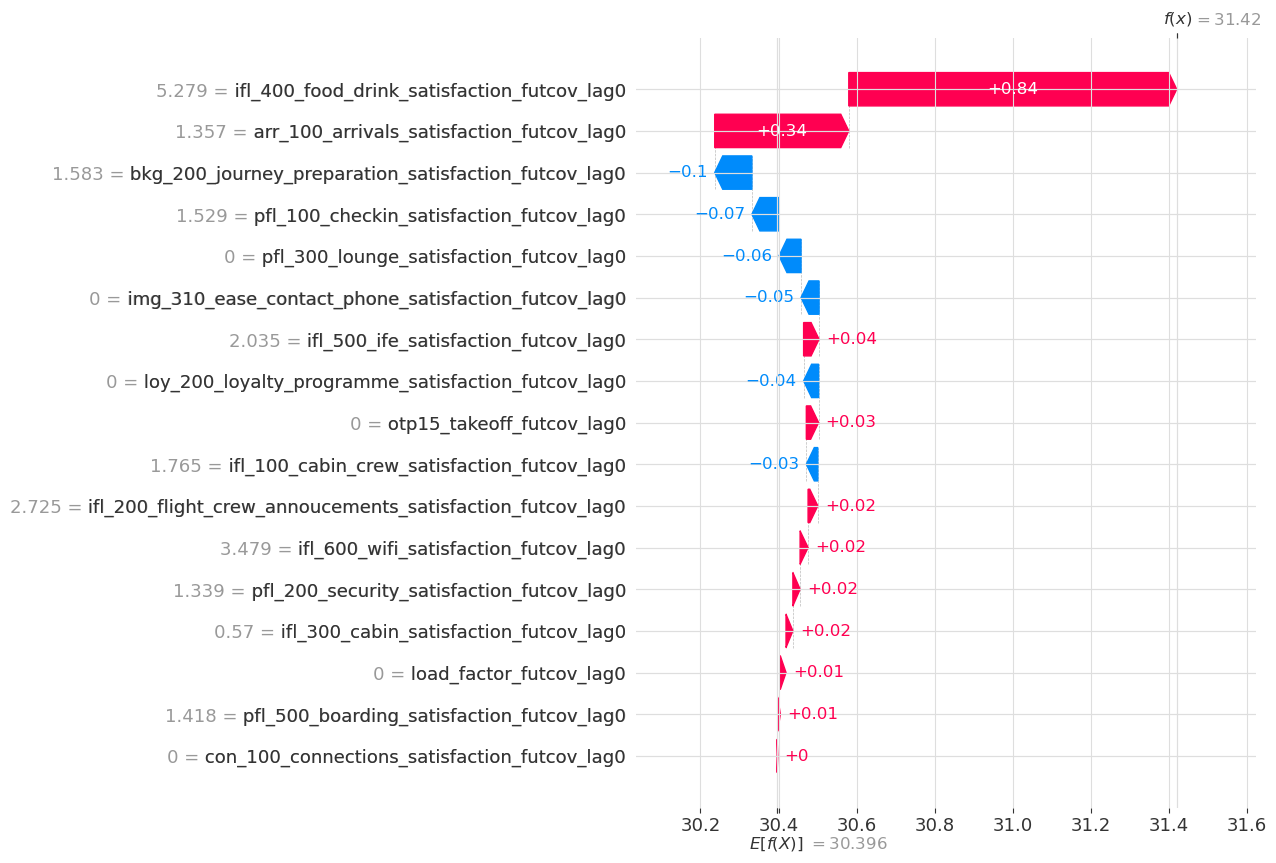

In [42]:
current_customer_initiatives={}
for key in annual_next_year_customer_initiatives_grouped_dfs.keys(): 
    current_customer_initiatives[key] = create_uplifting_explanation(unexpected_events_explanation[key][3], current_customer_initiatives_explanation[key][3] )
    print(key)
    shap.plots.waterfall(shap_values=current_customer_initiatives[key], max_display=20)

#### From (+operative performances and +unexpected events and + current customer inititiatives) 
#### to (+operative performances and +unexpected events and + current customer inititiatives and + next year customer initiatives)

Business_LH_df


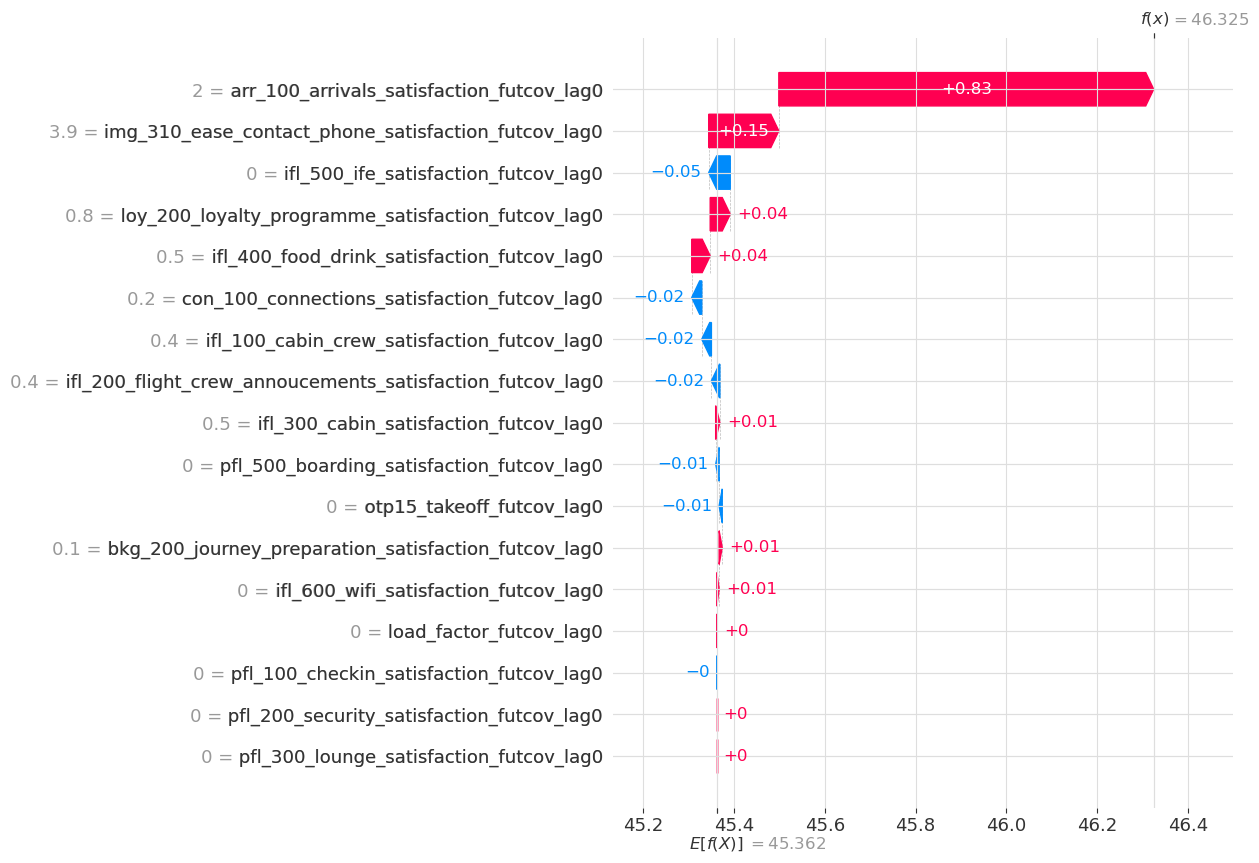

Business_SH_df


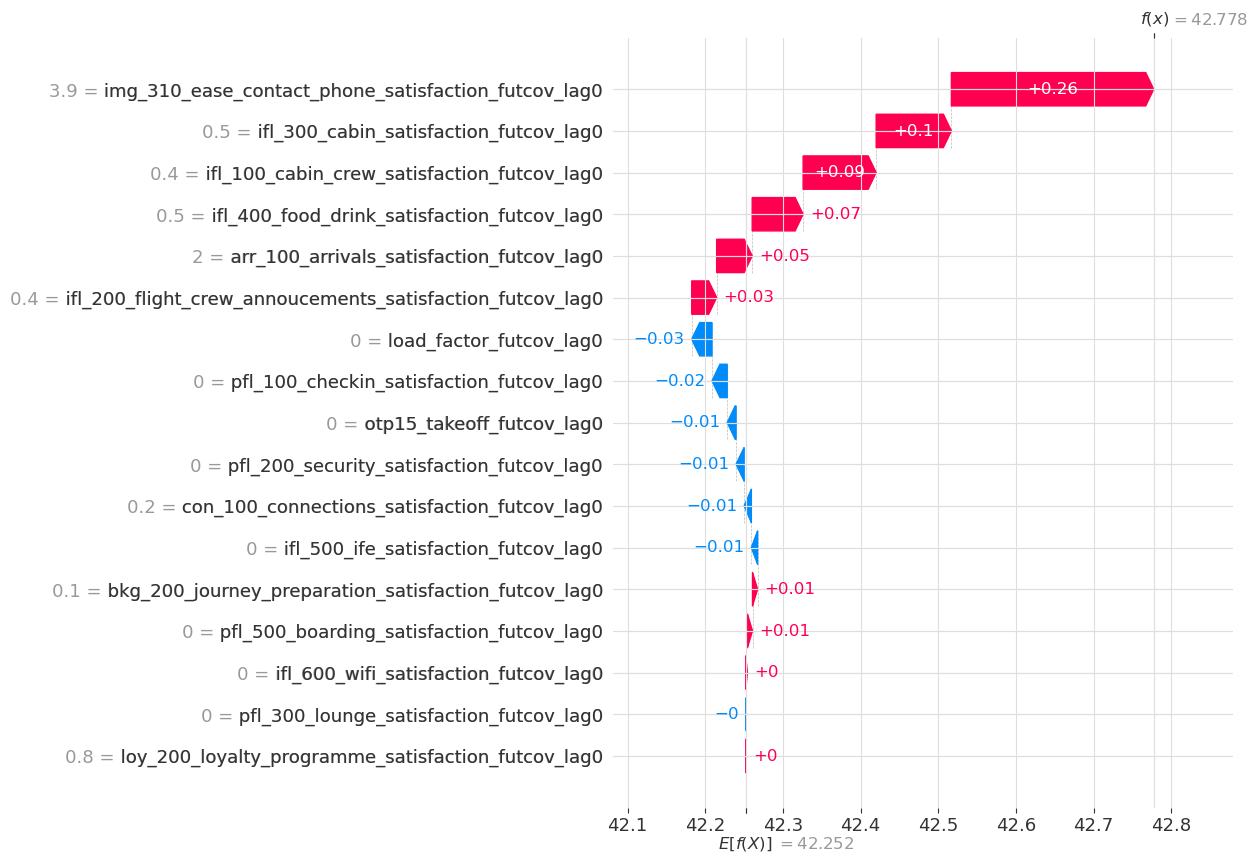

Economy_LH_df


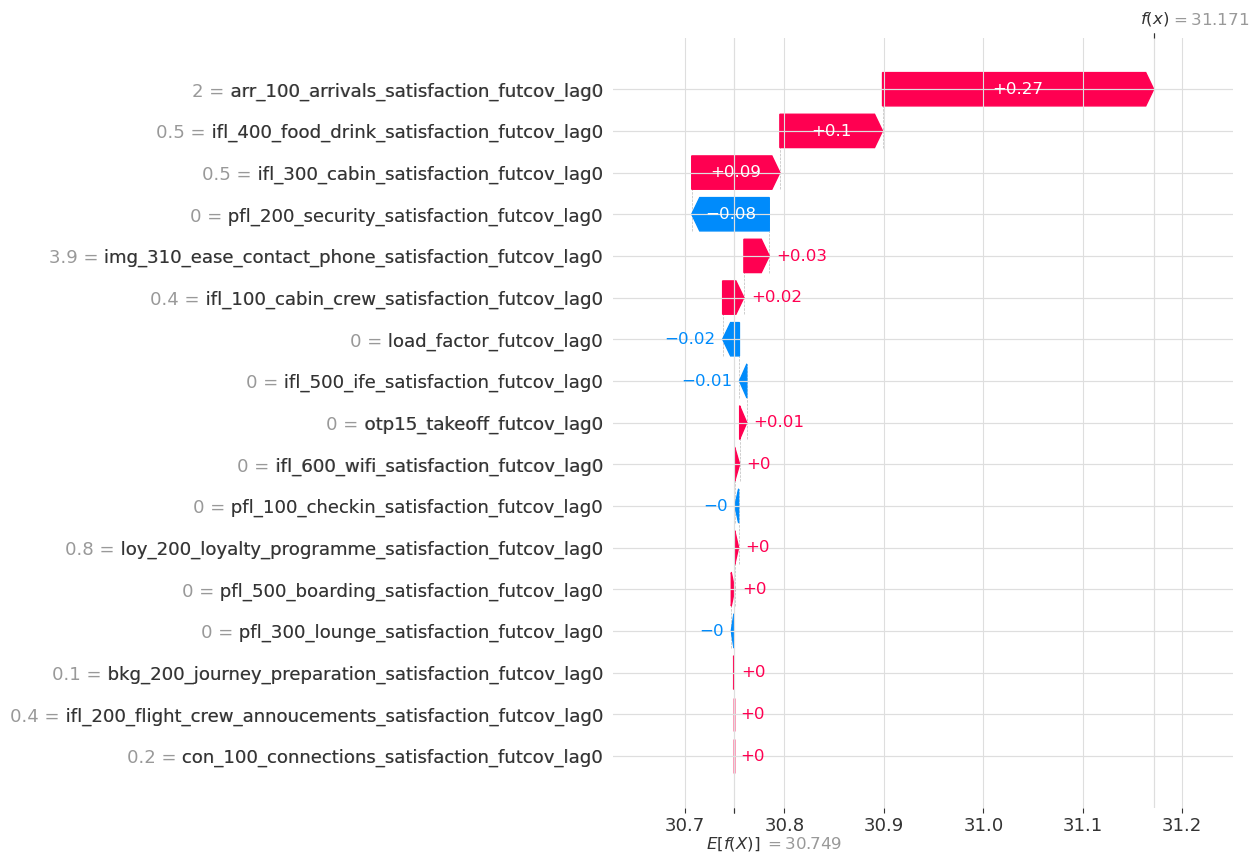

Economy_SH_df


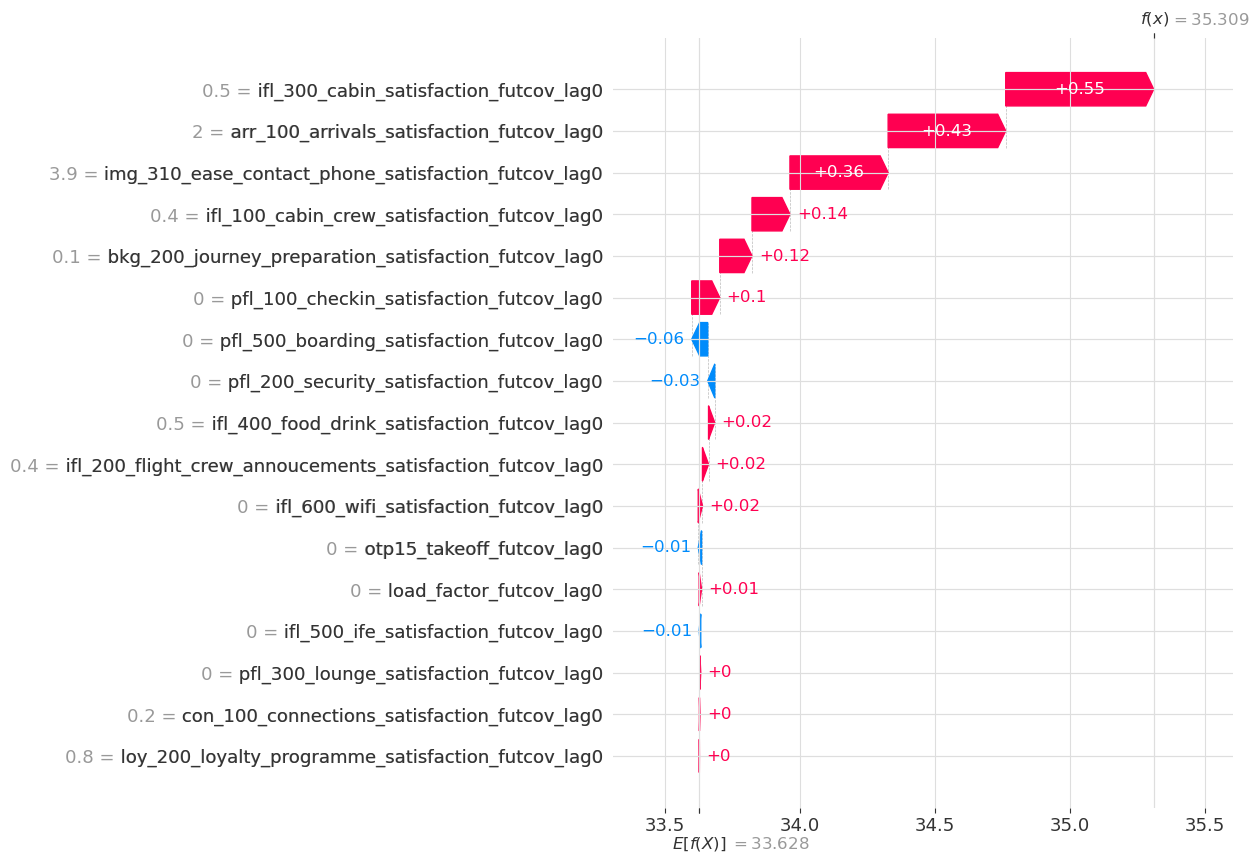

Premium Economy_LH_df


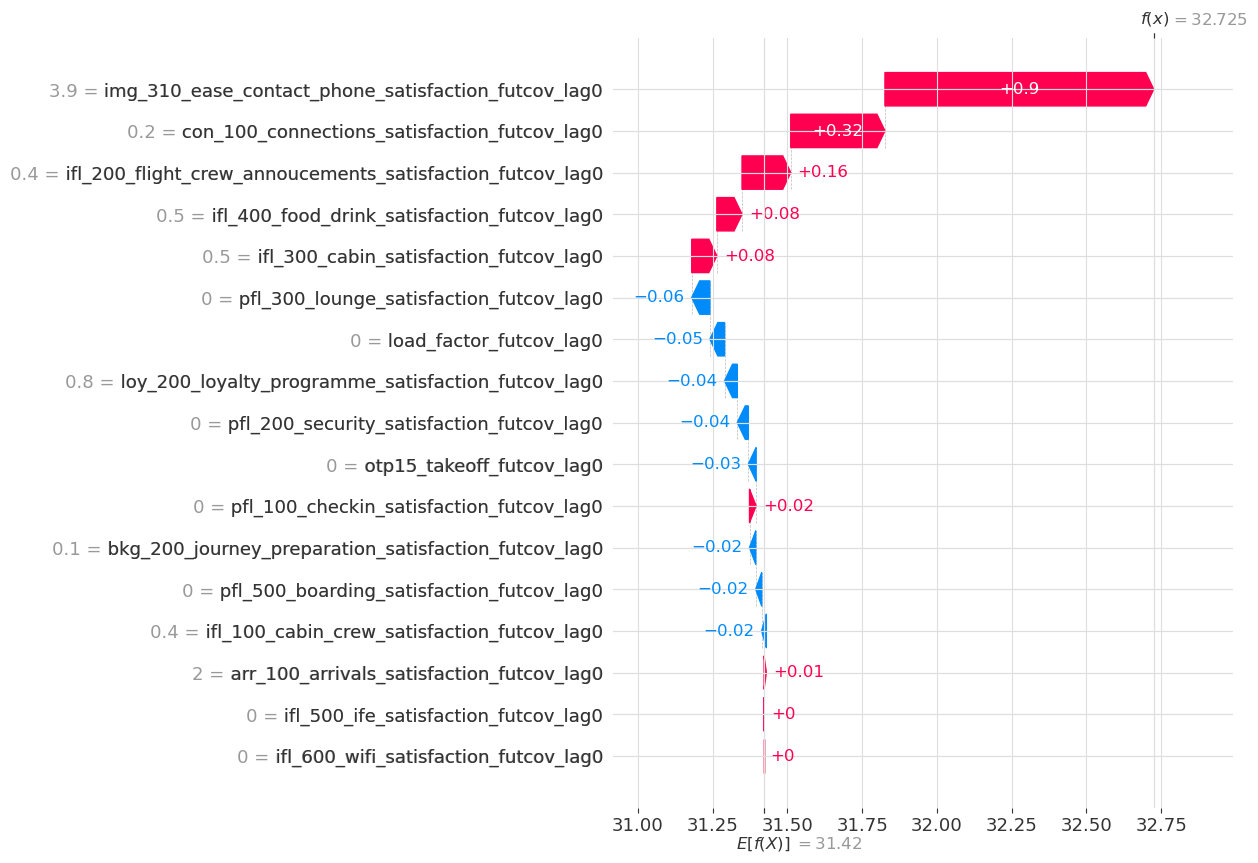

In [43]:
next_year_customer_initiatives={}
for key in annual_next_year_customer_initiatives_grouped_dfs.keys(): 
    next_year_customer_initiatives[key] = create_uplifting_explanation(current_customer_initiatives_explanation[key][3], next_year_customer_initiatives_explanation[key][3])
    print(key)
    shap.plots.waterfall(shap_values=next_year_customer_initiatives[key], max_display=20)

#### From current year to all at once.

Business_LH_df


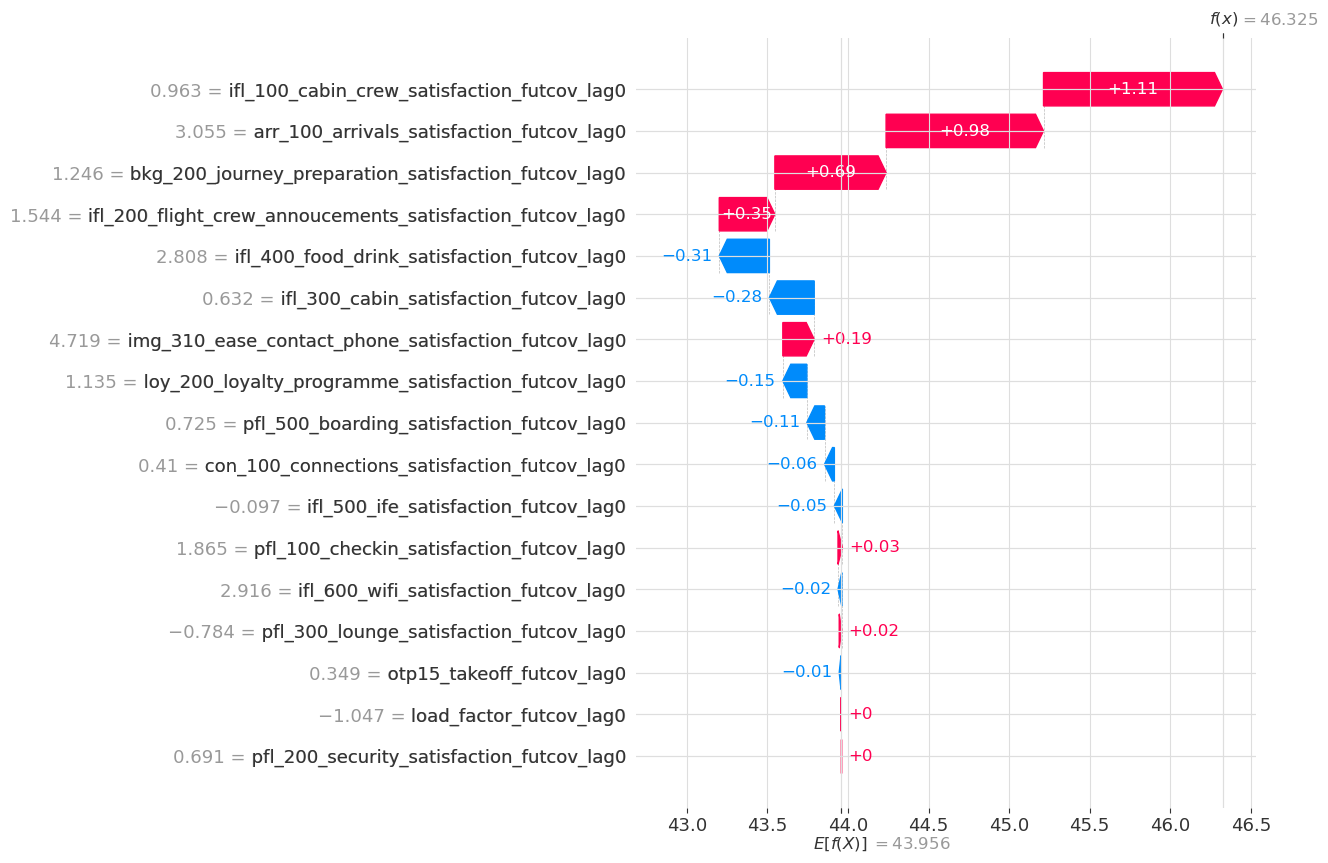

Business_SH_df


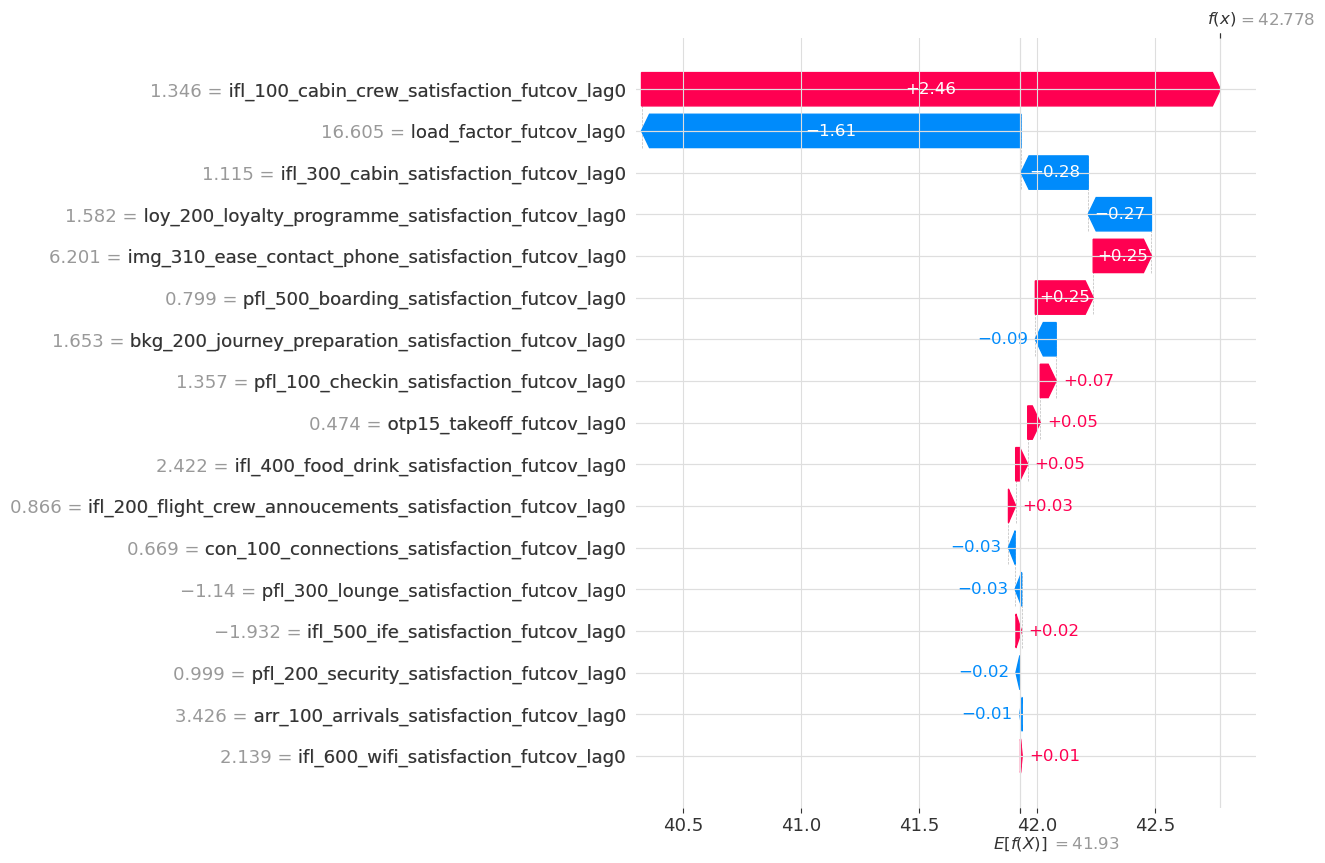

Economy_LH_df


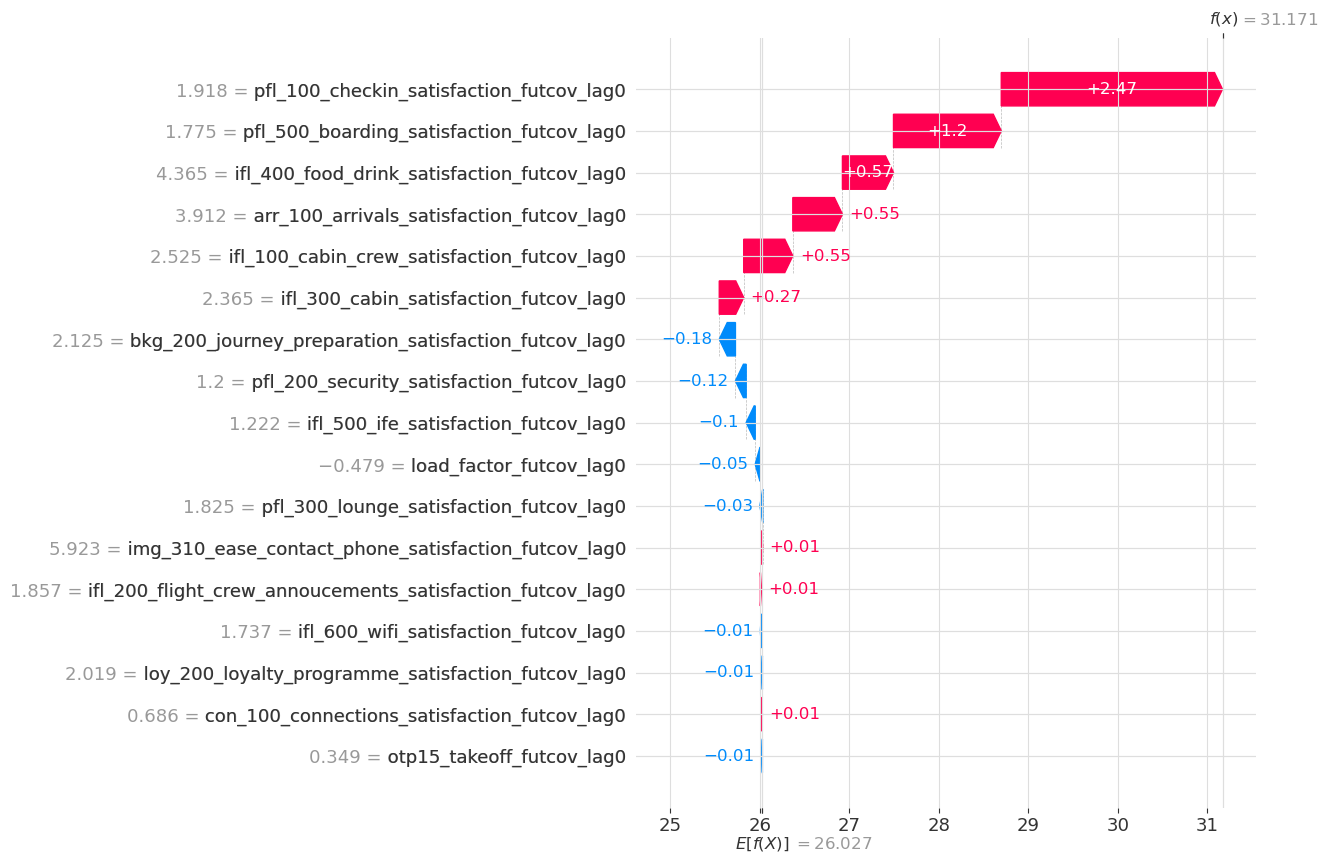

Economy_SH_df


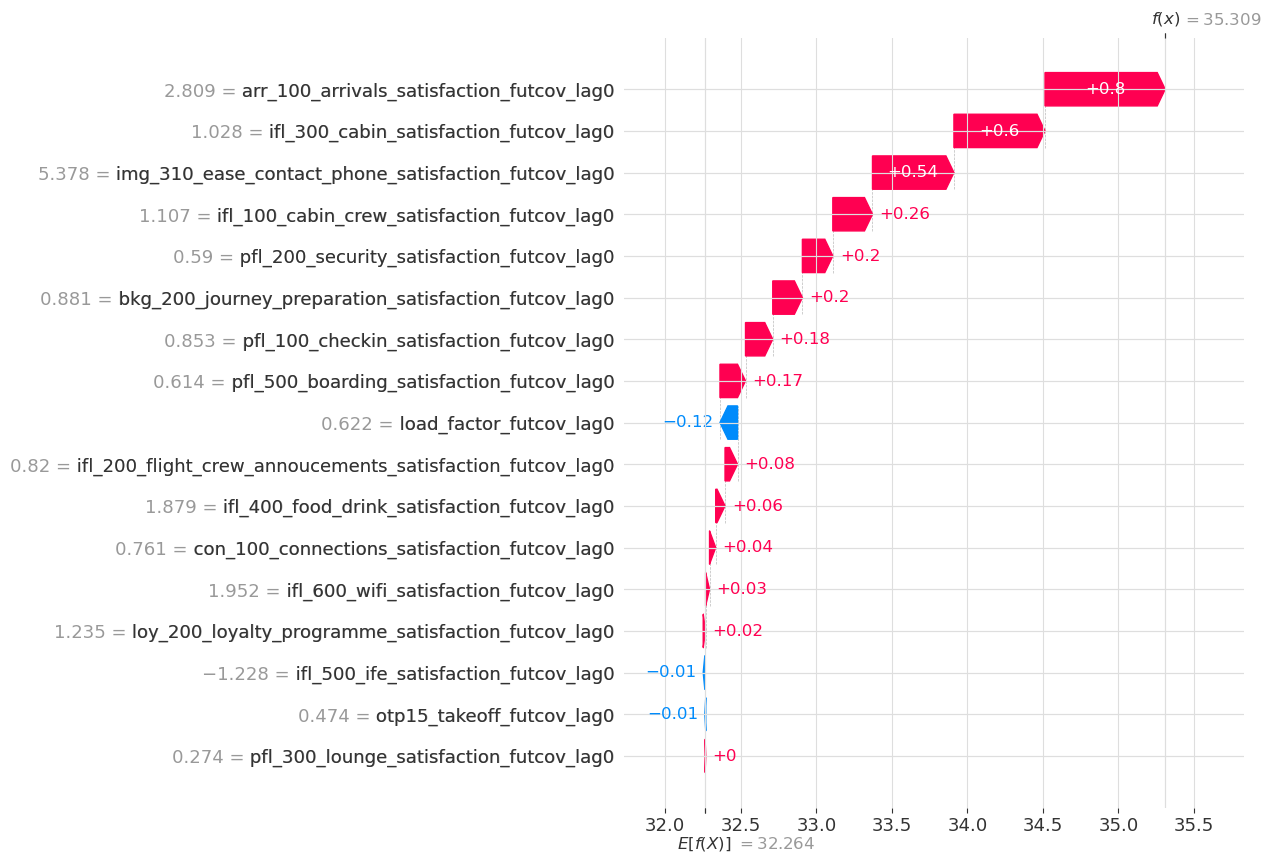

Premium Economy_LH_df


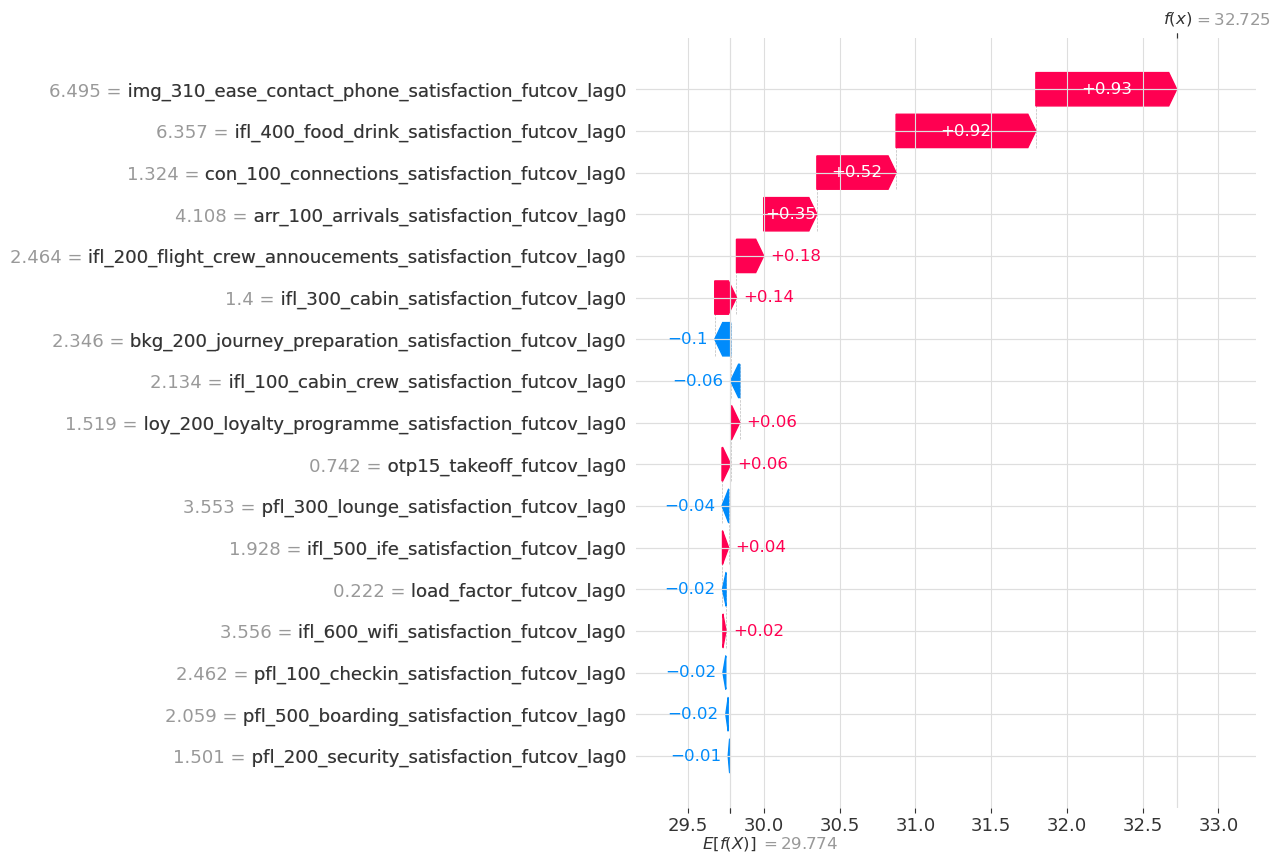

In [44]:
all_changes={}
for key in annual_next_year_customer_initiatives_grouped_dfs.keys(): 
    all_changes[key] = create_uplifting_explanation(next_year_customer_initiatives_explanation[key][2], next_year_customer_initiatives_explanation[key][3])
    print(key)
    shap.plots.waterfall(shap_values=all_changes[key], max_display=20)

### Get global NPS (current year weights)

In [45]:
touchpoint_feature_names=[tp for tp in operative_performance_explanation[key].feature_names if '_satisfaction' in tp]

In [46]:
import numpy as np
import shap

def weighted_shap_addition(explanation_objects, weight_cabin_haul):
    # Initialize aggregated SHAP values with zeros
    aggregated_shap_values = None
    aggregated_base_value = None
    aggregated_data = None
    aggregated_feature_names = []  # To store feature names
    
    # Iterate through each key in the explanation objects
    for key, explanation in explanation_objects.items():
        weighted_shap_values = []
        weighted_base_value = 0  # Initialize as zero for multiplication
        weighted_data = []

        for feature_name in explanation.feature_names:
            # Get the weight based on the feature name
            if feature_name in touchpoint_feature_names:
                weight = weight_cabin_haul['touchpoints'][key]
            elif 'otp15_takeoff' in feature_name:
                weight = weight_cabin_haul['otp15_takeoff'][key]
            elif 'load_factor' in feature_name:
                weight = weight_cabin_haul['load_factor'][key]
            else:
                continue  # Skip if feature name doesn't match any category

            # Multiply SHAP value by the weight
            weighted_shap = explanation[feature_name].values * weight
            weighted_dat = explanation[feature_name].data * weight

            # Accumulate the weighted values
            weighted_shap_values.append(weighted_shap)
            weighted_data.append(weighted_dat)

        # Calculate the weighted base value using the touchpoints weight
        weighted_base_value = explanation.base_values * weight_cabin_haul['touchpoints'][key]

        # Aggregate the weighted SHAP values for the current key
        if aggregated_shap_values is None:
            aggregated_shap_values = np.array(weighted_shap_values)
            aggregated_data = np.array(weighted_data)
            aggregated_base_value = weighted_base_value
        else:
            aggregated_shap_values += np.array(weighted_shap_values)
            aggregated_data += np.array(weighted_data)
            aggregated_base_value += weighted_base_value

        aggregated_feature_names.extend(explanation.feature_names)  # Accumulate feature names

    # Create a new Explanation object with the aggregated values
    aggregated_explanation = shap.Explanation(
        values=aggregated_shap_values,
        base_values=aggregated_base_value,
        data=aggregated_data,
        feature_names=aggregated_feature_names  # Use the accumulated feature names
    )

    return aggregated_explanation



In [47]:

# Usage example:
# Assuming explanation_objects is a dictionary with SHAP explanation objects and weight_cabin_haul is a dictionary with weights
# Call the function to get the aggregated SHAP values
operative_performance_aggregated_shap_values = weighted_shap_addition(operative_performance_explanation_objects, weight_cabin_haul_current_year)
unexpected_events_aggregated_shap_values = weighted_shap_addition(unexpected_events_explanation_objects, weight_cabin_haul_current_year)
current_customer_initiatives_aggregated_shap_values = weighted_shap_addition(current_customer_initiatives_explanation_objects, weight_cabin_haul_current_year)
next_year_customer_initiatives_aggregated_shap_values = weighted_shap_addition(next_year_customer_initiatives_explanation_objects, weight_cabin_haul_current_year)

### Get shapley explanation for global NPS

#### Operative performance uplift

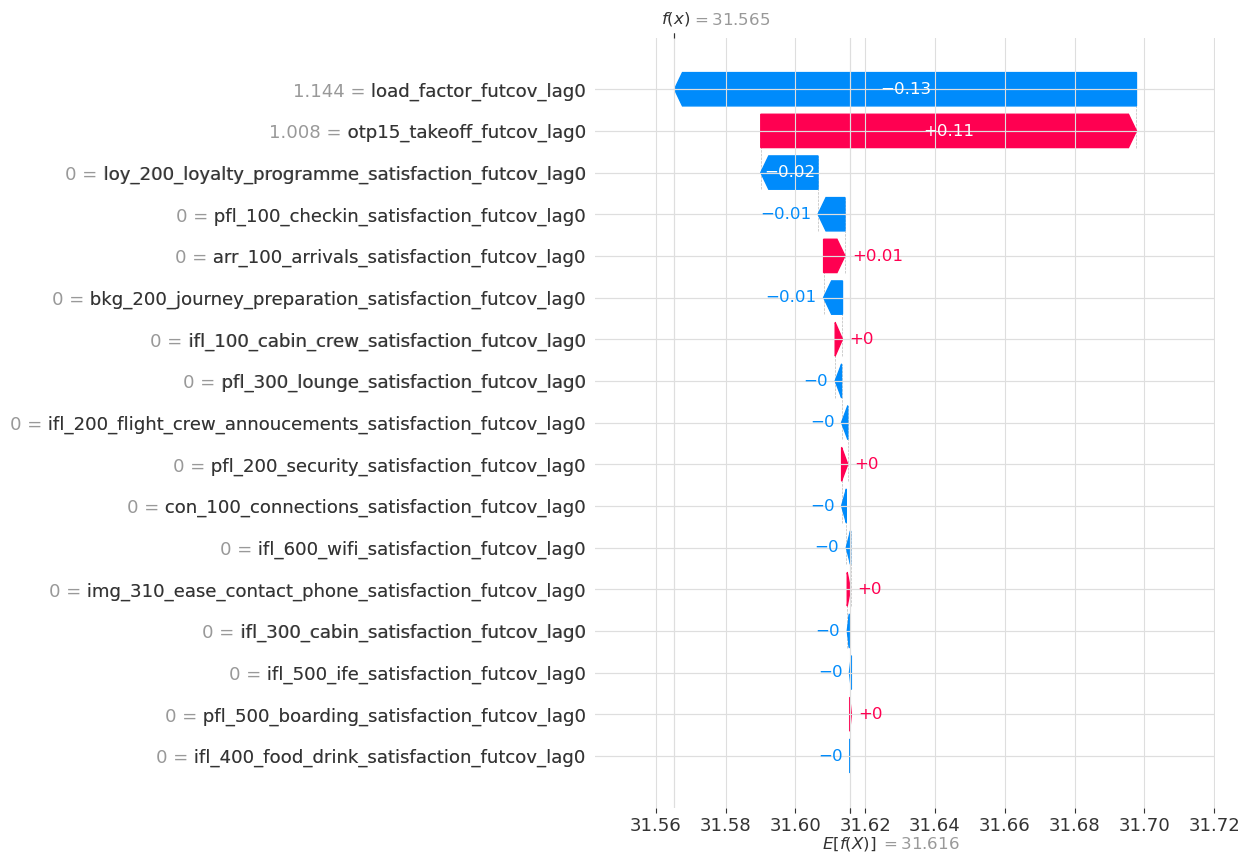

In [48]:
shap.plots.waterfall(shap_values=operative_performance_aggregated_shap_values, max_display=20)

#### Unexpected events uplift

In [49]:
first_uplift=create_uplifting_explanation(operative_performance_aggregated_shap_values,unexpected_events_aggregated_shap_values)

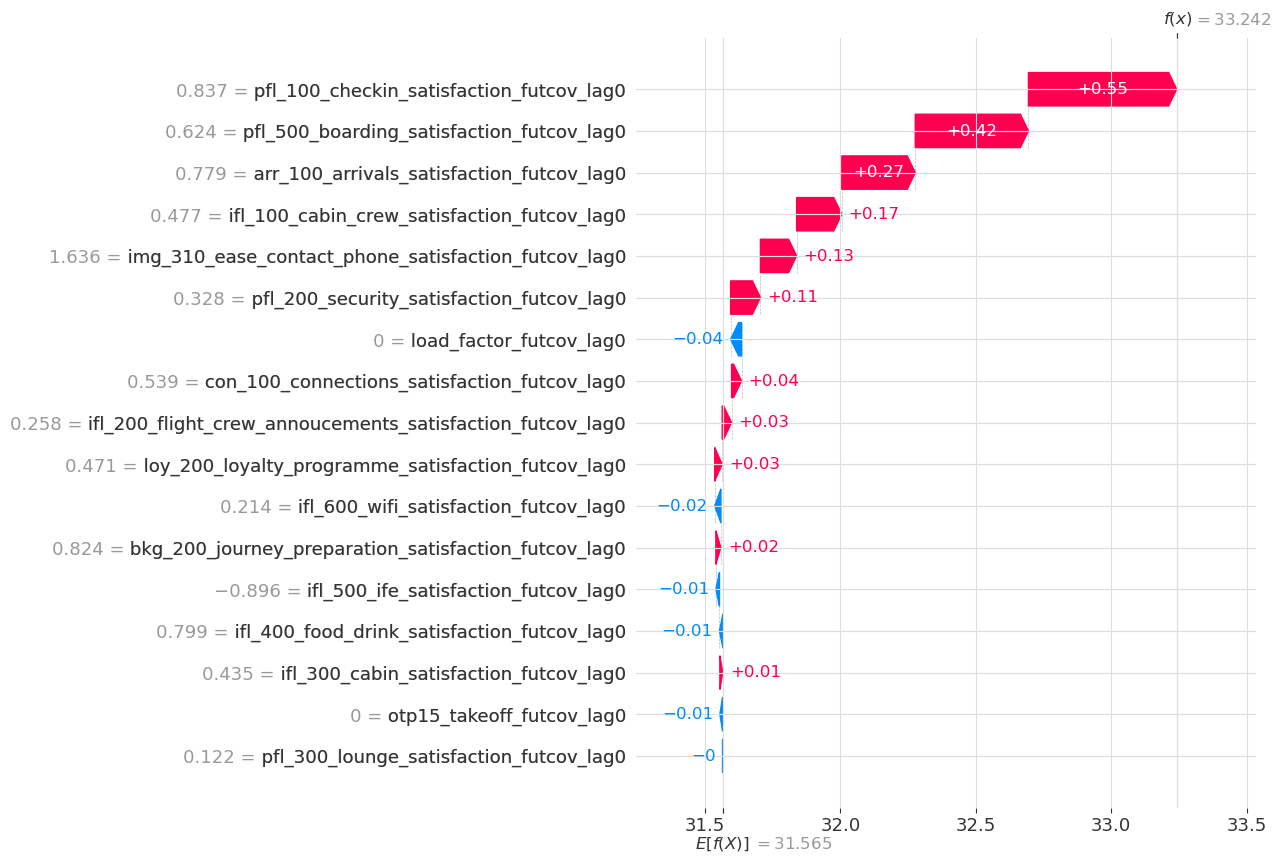

In [50]:
shap.plots.waterfall(shap_values=first_uplift, max_display=20)

#### Current customer initiatives uplift

In [51]:
second_uplift=create_uplifting_explanation(unexpected_events_aggregated_shap_values,current_customer_initiatives_aggregated_shap_values)

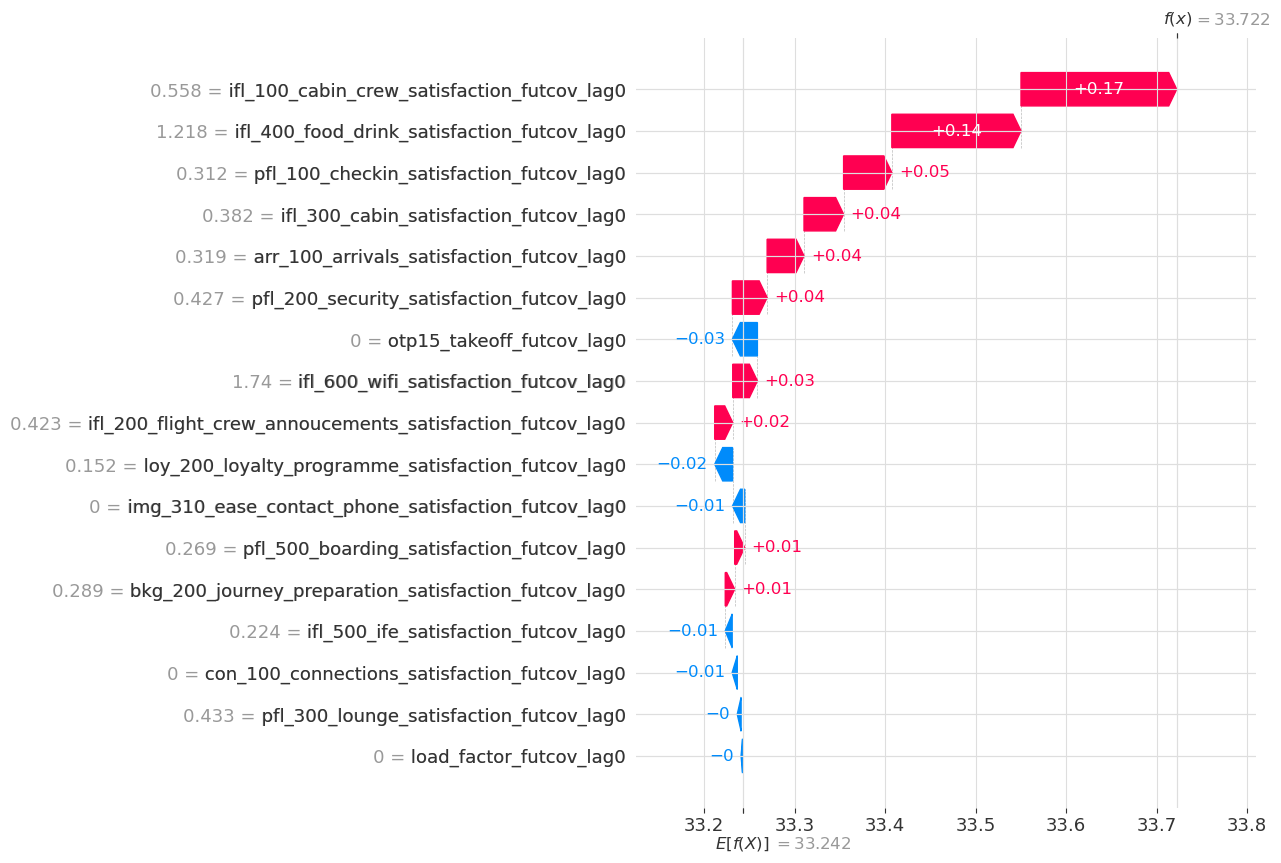

In [52]:
shap.plots.waterfall(shap_values=second_uplift, max_display=20)

#### Next year customer inititiatives uplift

In [53]:
third_uplift=create_uplifting_explanation(current_customer_initiatives_aggregated_shap_values,next_year_customer_initiatives_aggregated_shap_values)

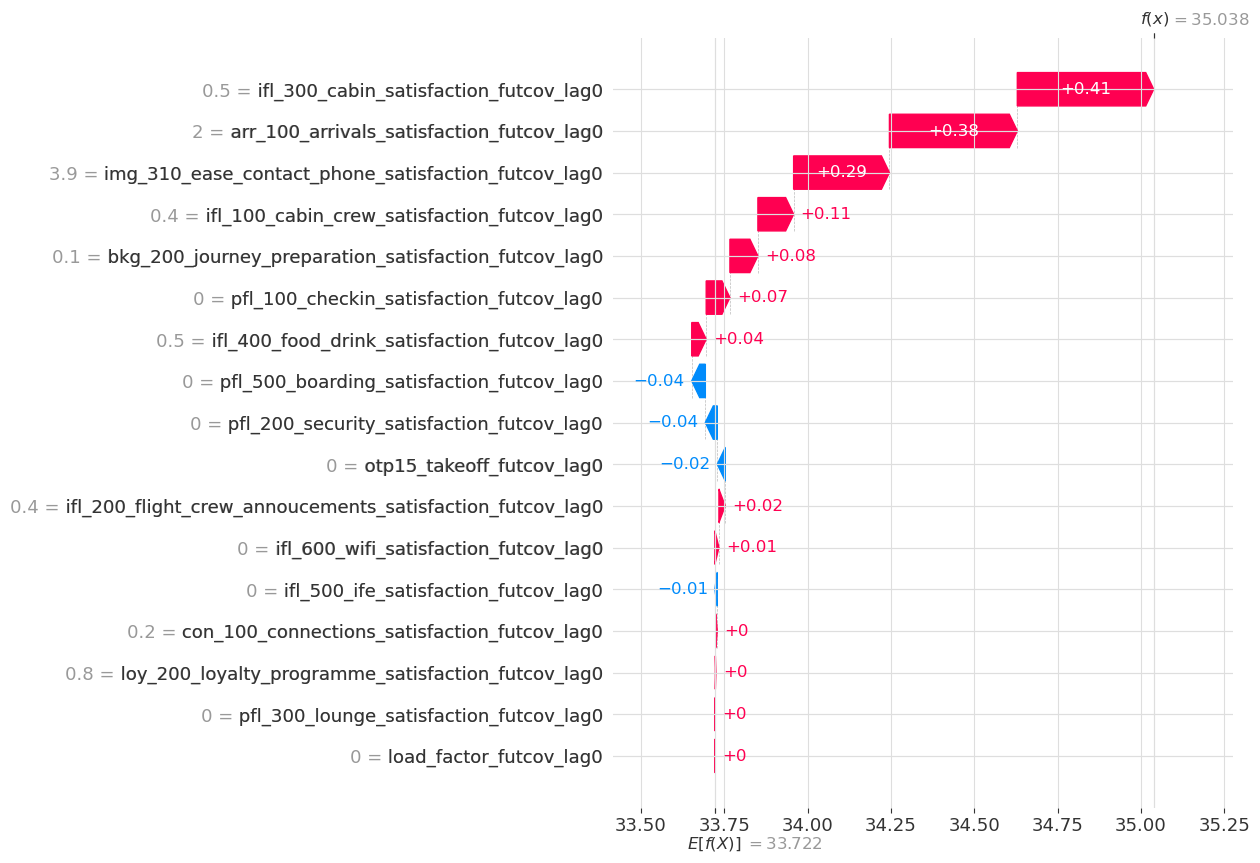

In [54]:
shap.plots.waterfall(shap_values=third_uplift, max_display=20)

## Cabin-Haul mix

In [55]:
weighted_shap_addition(next_year_customer_initiatives_explanation_objects, weight_cabin_haul_2024),next_year_customer_initiatives_aggregated_shap_values

(.values =
 array([ 0.10399825,  0.69657503,  0.11029654, -0.00565937,  0.40214374,
         0.46059585,  0.07166047,  0.01511306, -0.03002771,  0.18101582,
         0.44486764,  0.7024073 ,  0.03400361, -0.00643689,  0.40248919,
        -0.16652116,  0.04601115])
 
 .base_values =
 31.542787770783644
 
 .data =
 array([ 1.23106138,  1.16643711,  0.76365681,  0.58418787,  0.91139119,
         1.33605929,  1.09953112,  1.9558356 , -0.63103552,  2.55755513,
         1.45541998,  3.11628253,  0.73941291,  1.43385759,  5.54595263,
         1.06131642,  1.00774628]),
 .values =
 array([ 0.10725248,  0.66434782,  0.11433948, -0.0052638 ,  0.38852228,
         0.46327648,  0.07172734,  0.01565315, -0.02858625,  0.17366769,
         0.44799484,  0.70184486,  0.03387097, -0.00693733,  0.40843516,
        -0.17359774,  0.04601115])
 
 .base_values =
 31.615601496923606
 
 .data =
 array([ 1.21365764,  1.1490563 ,  0.75504199,  0.5553809 ,  0.89359156,
         1.31708562,  1.08128661,  1.9541072

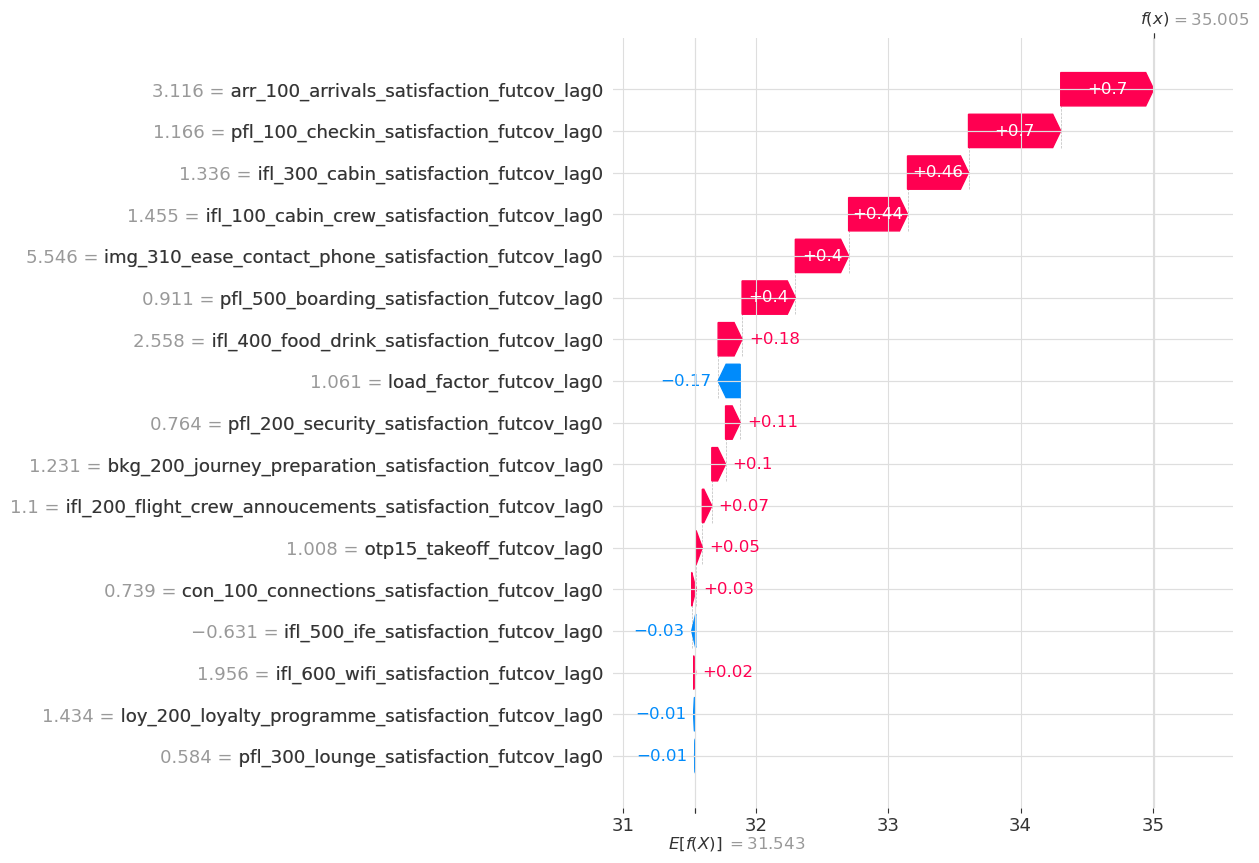

In [56]:
shap.plots.waterfall(shap_values=weighted_shap_addition(next_year_customer_initiatives_explanation_objects, weight_cabin_haul_2024), max_display=20)

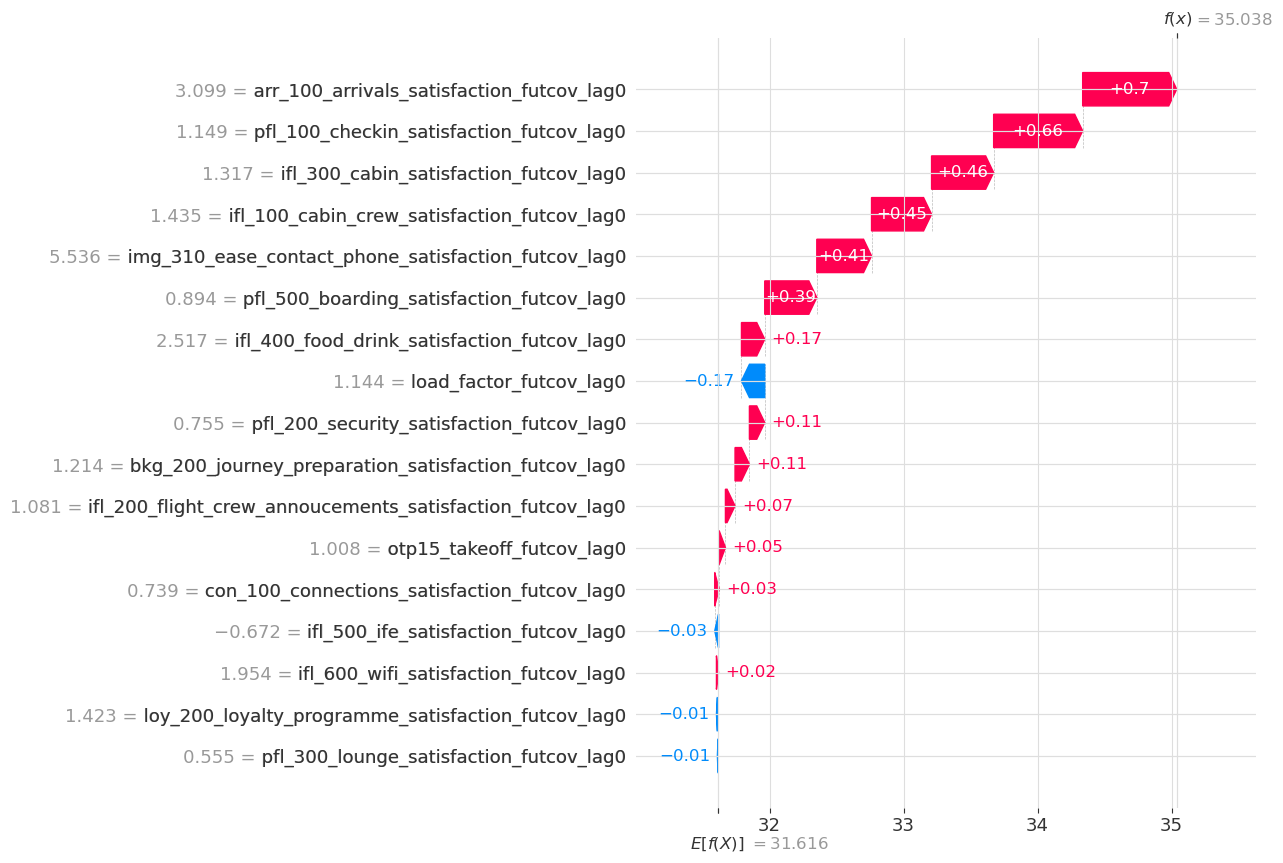

In [57]:
shap.plots.waterfall(shap_values=next_year_customer_initiatives_aggregated_shap_values, max_display=20)